Tracks after filtering: 41398
   track_index  lifetime  max_size_points  mean_size_points  merges_total  \
0          774         1           7636.0       7636.000000             0   
1          777         1            211.0        211.000000             0   
2          778         3             52.0         30.000000             1   
3          779         2            782.0        718.500000             1   
4          780         3           1404.0        618.333313             1   

   splits_total  mass_flux_metric merge_class  merged_flag  
0             0      2.956012e+06           0        False  
1             0      5.238755e+04           0        False  
2             0      8.999102e+03           1         True  
3             1      4.954714e+05           1         True  
4             2      6.890933e+05           1         True  


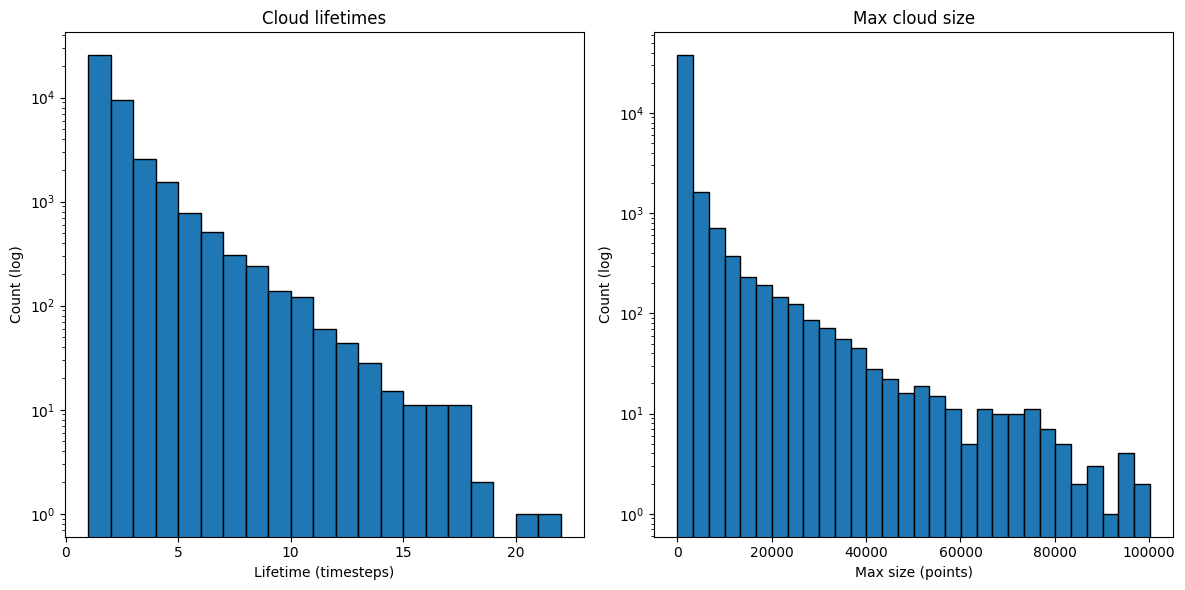

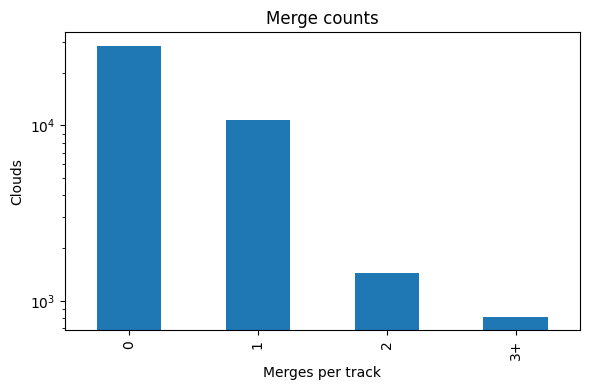

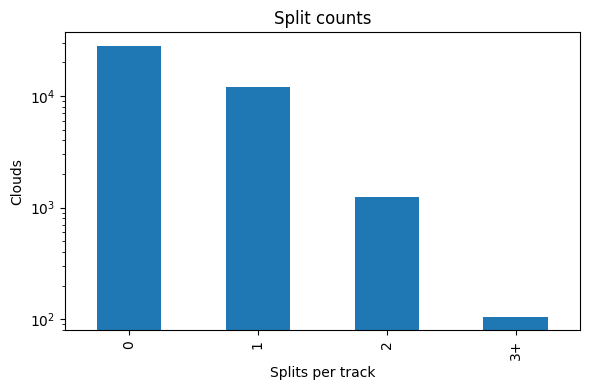

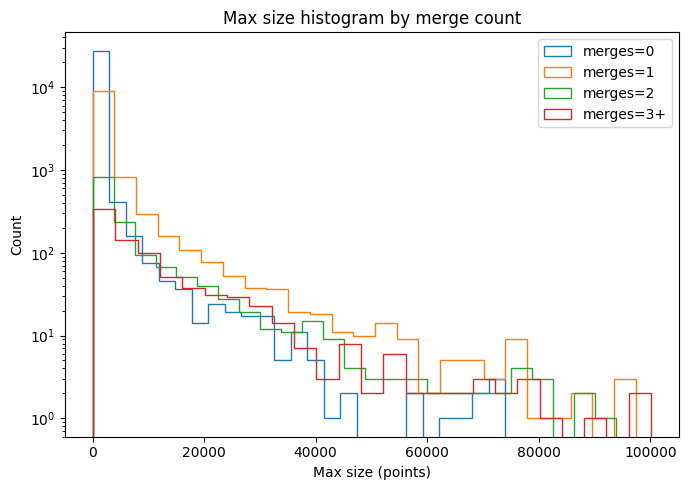

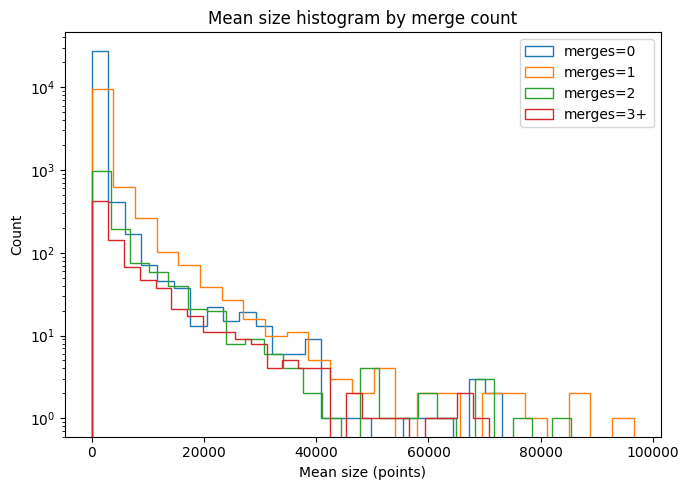

In [10]:
# PARAMETERS
#nc_file = "../cloud_results.nc"
nc_file = "../output_archive/cloud_results_120mins.nc"
min_max_size_points = 10        # Track must reach at least this many voxels once
min_lifetime_steps = 1        # Track must exist (non-NaN size) at least this many timesteps
use_integrated_mass_flux = True  # If True: sum over time; else: time-mean
time_step_seconds = 60           # Needed only if you want to scale integrated flux by dt
volume_dx = 25.0                 # Horizontal grid (m)
volume_dy = 25.0                 # Horizontal grid (m)
# For voxel vertical thickness we infer per level (variable height spacing allowed)

# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import seaborn as sns

# ---------------- Core extraction & processing ---------------- #
def load_tracks(nc_path):
    def read_opt(ds, name):
        var = ds.variables.get(name)
        return np.ma.filled(var[:], np.nan) if var is not None else None
    with Dataset(nc_path) as ds:
        valid_track = np.asarray(ds.variables['valid_track'][:])
        size = np.ma.filled(ds.variables['size'][:], np.nan)
        mass_flux = np.ma.filled(ds.variables['mass_flux'][:], np.nan)
        merges_count = np.ma.filled(ds.variables['merges_count'][:], 0)
        splits_count = np.ma.filled(ds.variables['splits_count'][:], 0)
        height = np.asarray(ds.variables['height'][:])
        

        # optionals (properly sliced)
        cloud_base_area = read_opt(ds, 'cloud_base_area')
        max_height = read_opt(ds, 'max_height')
        cloud_base_height = read_opt(ds, 'cloud_base_height')
        base_radius_diagnosed = read_opt(ds, 'base_radius_diagnosed')
        base_radius_prescribed = read_opt(ds, 'base_radius_prescribed')
        max_w_cloud_base = read_opt(ds, 'max_w_cloud_base')
        w_per_level = read_opt(ds, 'w_per_level')  # (track,time,level)
        surface_area = read_opt(ds, 'surface_area')
        

    return dict(
        valid_track=valid_track,
        size=size,
        mass_flux=mass_flux,
        merges_count=merges_count.astype(np.int32),
        splits_count=splits_count.astype(np.int32),
        height=height,
        cloud_base_area=cloud_base_area,
        max_height=max_height,
        cloud_base_height=cloud_base_height,
        base_radius_diagnosed=base_radius_diagnosed,
        base_radius_prescribed=base_radius_prescribed,
        max_w_cloud_base=max_w_cloud_base,
        surface_area=surface_area,
        w_per_level=w_per_level,
    )






def build_track_dataframe(data, min_max_size_points, min_lifetime_steps,
                          use_integrated_mass_flux, time_step_seconds,
                          voxel_volume_per_level=None):
    valid_mask = data['valid_track'] == 1
    size = np.asarray(data['size'])                  # already filled
    mass_flux = np.asarray(data['mass_flux'])
    merges = np.asarray(data['merges_count'])
    splits = np.asarray(data['splits_count'])

    n_tracks, n_time = size.shape
    records = []
    for i in range(n_tracks):
        if not valid_mask[i]:
            continue

        size_row = size[i]  # (time,)
        # timesteps where size is real (not NaN and >0)
        valid_timesteps = np.isfinite(size_row)
        lifetime = int(valid_timesteps.sum())
        if lifetime == 0:
            continue

        max_size = np.nanmax(size_row)
        if (max_size < min_max_size_points) or (lifetime < min_lifetime_steps):
            continue

        # Safe sums (arrays are plain ndarrays now)
        merges_total = int(merges[i, valid_timesteps].sum())
        splits_total = int(splits[i, valid_timesteps].sum())

        mf_row = mass_flux[i]
        if use_integrated_mass_flux:
            mf_val = np.nansum(mf_row[valid_timesteps])  # * time_step_seconds if physical time integration needed
        else:
            mf_val = float(np.nanmean(mf_row[valid_timesteps]))

        mean_size = float(np.nanmean(size_row[valid_timesteps]))

        records.append(dict(track_index=i,
                            lifetime=lifetime,
                            max_size_points=max_size,
                            mean_size_points=mean_size,
                            merges_total=merges_total,
                            splits_total=splits_total,
                            mass_flux_metric=mf_val))
    return pd.DataFrame.from_records(records)


def infer_voxel_volumes(height, dx, dy):
    # Derive per-level thickness (Δz). Last level thickness = median of previous (fallback)
    z = np.asarray(height, dtype=float)
    if z.size < 2:
        dz = np.array([1.0])
    else:
        dz_mid = np.diff(z)
        last = np.median(dz_mid)
        dz = np.concatenate([dz_mid, [last]])
    # Return per-level voxel volume (m3)
    return dx * dy * dz


def categorize_merges(df):
    def cat(m):
        if m == 0: return "0"
        if m == 1: return "1"
        if m == 2: return "2"
        return "3+"
    return df.assign(merge_class=df.merges_total.map(cat),
                     merged_flag=(df.merges_total > 0))



# Remove the density plots: plot_size_distributions

# ---------------- Plotting helpers ---------------- #
def plot_basic_histograms(df):
    """Basic histograms of lifetimes and max sizes."""
    if df.empty:
        print("No tracks after filtering.")
        return
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    life_max = int(df.lifetime.max())
    axes[0].hist(df.lifetime, bins=range(1, life_max + 2), edgecolor='black')
    axes[0].set_xlabel("Lifetime (timesteps)")
    axes[0].set_ylabel("Count (log)")
    axes[0].set_title("Cloud lifetimes")
    axes[0].set_yscale('log')
    axes[1].hist(df.max_size_points, bins=30, edgecolor='black')
    axes[1].set_xlabel("Max size (points)")
    axes[1].set_ylabel("Count (log)")
    axes[1].set_title("Max cloud size")
    axes[1].set_yscale('log')
    plt.tight_layout()

def plot_merge_frequency_counts(df):
    counts = df['merge_class'].value_counts().reindex(["0","1","2","3+"], fill_value=0)
    plt.figure(figsize=(6,4))
    counts.plot(kind='bar')
    plt.ylabel("Clouds")
    plt.xlabel("Merges per track")
    plt.yscale('log')
    plt.title("Merge counts")
    plt.tight_layout()

def plot_split_frequency_counts(df):
    def scat(s):
        if s == 0: return "0"
        if s == 1: return "1"
        if s == 2: return "2"
        return "3+"
    counts = df.splits_total.map(scat).value_counts().reindex(["0","1","2","3+"], fill_value=0)
    plt.figure(figsize=(6,4))
    counts.plot(kind='bar')
    plt.ylabel("Clouds")
    plt.xlabel("Splits per track")
    plt.yscale('log')
    plt.title("Split counts")
    plt.tight_layout()

def plot_size_histogram(df, which='max', bins=30, log=False):
    metric = 'max_size_points' if which=='max' else 'mean_size_points'
    plt.figure(figsize=(7,5))
    order = ["0","1","2","3+"]
    for cls in order:
        subset = df[df.merge_class == cls][metric]
        if subset.empty: 
            continue
        plt.hist(subset, bins=bins, histtype='step', label=f"merges={cls}", log=log)
    plt.xlabel(f"{which.capitalize()} size (points)")
    plt.ylabel("Count" + (" (log)" if log else ""))
    plt.yscale('log')
    plt.title(f"{which.capitalize()} size histogram by merge count")
    plt.legend()
    plt.tight_layout()

# ---------------- Run pipeline ---------------- #
raw = load_tracks(nc_file)
voxel_vol = infer_voxel_volumes(raw['height'], volume_dx, volume_dy)  # still optional

df_tracks = build_track_dataframe(raw,
                                  min_max_size_points=min_max_size_points,
                                  min_lifetime_steps=min_lifetime_steps,
                                  use_integrated_mass_flux=use_integrated_mass_flux,
                                  time_step_seconds=time_step_seconds)

df_tracks = categorize_merges(df_tracks)

print(f"Tracks after filtering: {len(df_tracks)}")
print(df_tracks.head())

# Basic overview histograms first
plot_basic_histograms(df_tracks)

# Other summaries
plot_merge_frequency_counts(df_tracks)
plot_split_frequency_counts(df_tracks)
plot_size_histogram(df_tracks, which='max', bins=25, log=False)
plot_size_histogram(df_tracks, which='mean', bins=25, log=False)
plt.show()

# Are merged clouds responsible for a disproportionate share of convective mass flux compared to single clouds?

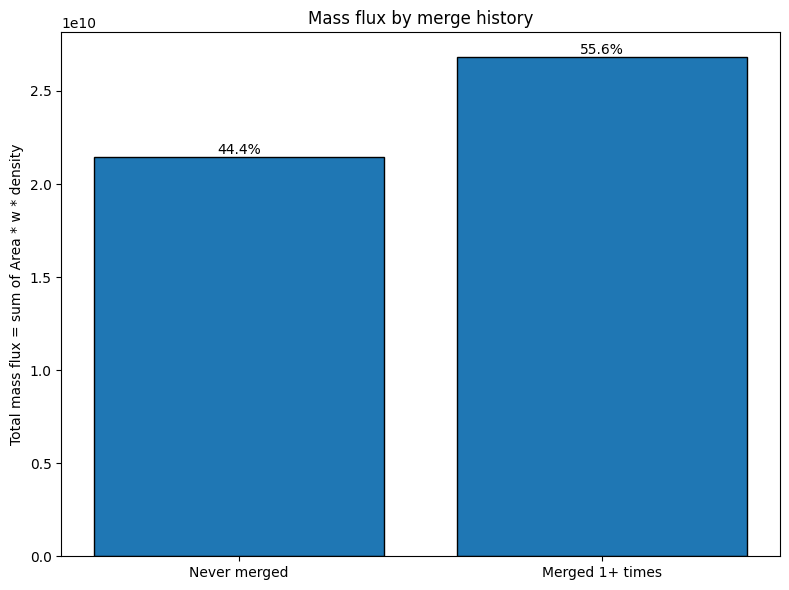

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset

def sum_mass_flux_by_merge_status(nc_file):
    """
    Sums mass flux for merged and non-merged clouds at each timestep,
    avoiding double-counting due to merges.
    Returns total mass flux for each category.
    """
    with Dataset(nc_file) as ds:
        mass_flux = np.ma.filled(ds.variables['mass_flux'][:], np.nan)  # (track, time)
        valid_track = np.asarray(ds.variables['valid_track'][:])         # (track,)
        size = np.ma.filled(ds.variables['size'][:], np.nan)             # (track, time)
        merges_count = np.ma.filled(ds.variables['merges_count'][:], 0)  # (track, time)

        n_tracks, n_time = mass_flux.shape

        # For each timestep, sum mass flux for all clouds present, grouped by merge status
        merged_flux = 0.0
        non_merged_flux = 0.0

        for t in range(n_time):
            mask = (valid_track == 1) & np.isfinite(size[:, t]) & (size[:, t] > 0)
            merged_mask = mask & (merges_count[:, t] > 0)
            non_merged_mask = mask & (merges_count[:, t] == 0)
            merged_flux += np.nansum(mass_flux[merged_mask, t])
            non_merged_flux += np.nansum(mass_flux[non_merged_mask, t])

        return non_merged_flux, merged_flux

# Compute total mass flux for merged and non-merged clouds
#non_merged_flux, merged_flux = sum_mass_flux_by_merge_status("../cloud_results.nc")
non_merged_flux, merged_flux = sum_mass_flux_by_merge_status("../output_archive/cloud_results_120mins.nc")

# Plot
labels = ['Never merged', 'Merged 1+ times']
values = [non_merged_flux, merged_flux]
plt.figure(figsize=(8,6))
plt.bar(labels, values, edgecolor='black')
plt.ylabel("Total mass flux = sum of Area * w * density")
plt.title("Mass flux by merge history")
if sum(values) > 0:
    pct = 100 * np.array(values) / sum(values)
    for i, (p) in enumerate(pct):
        plt.text(i, values[i], f"{p:.1f}%", ha='center', va='bottom')
plt.tight_layout()
plt.show()

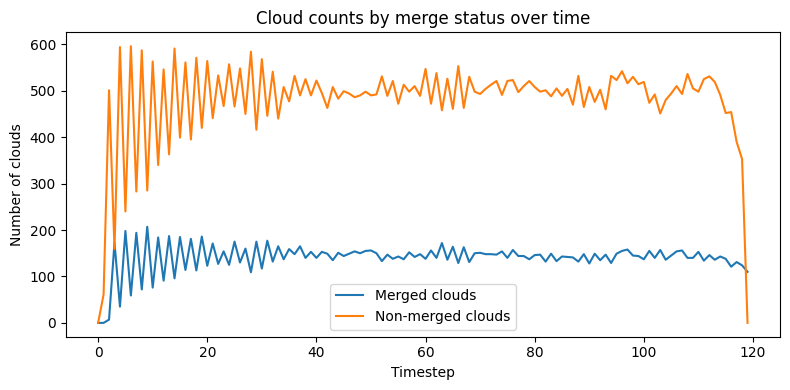

In [7]:
def count_clouds_by_merge_status(nc_file):
    with Dataset(nc_file) as ds:
        valid_track = np.asarray(ds.variables['valid_track'][:])
        size = np.ma.filled(ds.variables['size'][:], np.nan)
        merges_count = np.ma.filled(ds.variables['merges_count'][:], 0)
        n_tracks, n_time = size.shape

        merged_counts = []
        non_merged_counts = []
        for t in range(n_time):
            mask = (valid_track == 1) & np.isfinite(size[:, t]) & (size[:, t] > 0)
            merged_mask = mask & (merges_count[:, t] > 0)
            non_merged_mask = mask & (merges_count[:, t] == 0)
            merged_counts.append(np.sum(merged_mask))
            non_merged_counts.append(np.sum(non_merged_mask))
        return np.array(merged_counts), np.array(non_merged_counts)

#merged_counts, non_merged_counts = count_clouds_by_merge_status("../cloud_results.nc")
merged_counts, non_merged_counts = count_clouds_by_merge_status("../output_archive/cloud_results_120mins.nc")
plt.figure(figsize=(8,4))
plt.plot(merged_counts, label='Merged clouds')
plt.plot(non_merged_counts, label='Non-merged clouds')
plt.xlabel("Timestep")
plt.ylabel("Number of clouds")
plt.title("Cloud counts by merge status over time")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
mean_merged_flux = merged_flux / merged_counts.sum()
mean_non_merged_flux = non_merged_flux / non_merged_counts.sum()
print(f"Mean mass flux per merged cloud: {mean_merged_flux:.2e}")
print(f"Mean mass flux per non-merged cloud: {mean_non_merged_flux:.2e}")

Mean mass flux per merged cloud: 1.59e+06
Mean mass flux per non-merged cloud: 3.74e+05


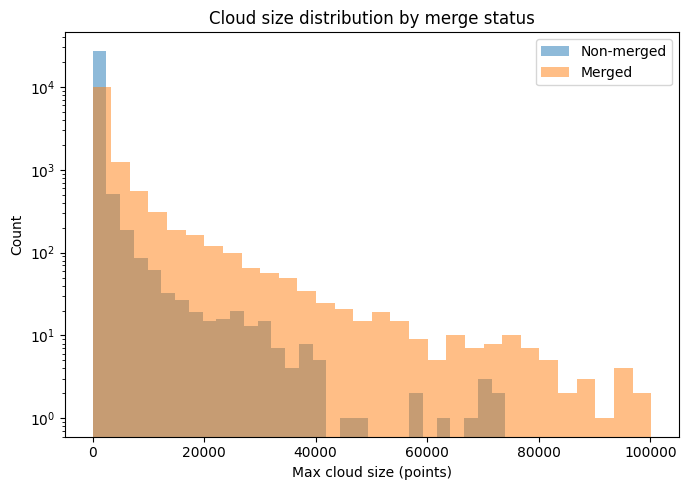

In [9]:
# If you have a DataFrame of tracks:
plt.figure(figsize=(7,5))
for label, flag in zip(['Non-merged', 'Merged'], [False, True]):
    subset = df_tracks[df_tracks.merged_flag == flag]
    plt.hist(subset.max_size_points, bins=30, alpha=0.5, label=label)
plt.xlabel("Max cloud size (points)")
plt.ylabel("Count")
plt.yscale("log")
plt.title("Cloud size distribution by merge status")
plt.legend()
plt.tight_layout()
plt.show()

# vertical velocity and branchiness  

Relationship between max cloud base w and max cloud size (and max cloud top height, and max branchiness)

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_14174/2534311485.py:16: RuntimeWarning: All-NaN slice encountered
  max_updraft = np.nanmax(w_vals_pos, axis=(1,2))


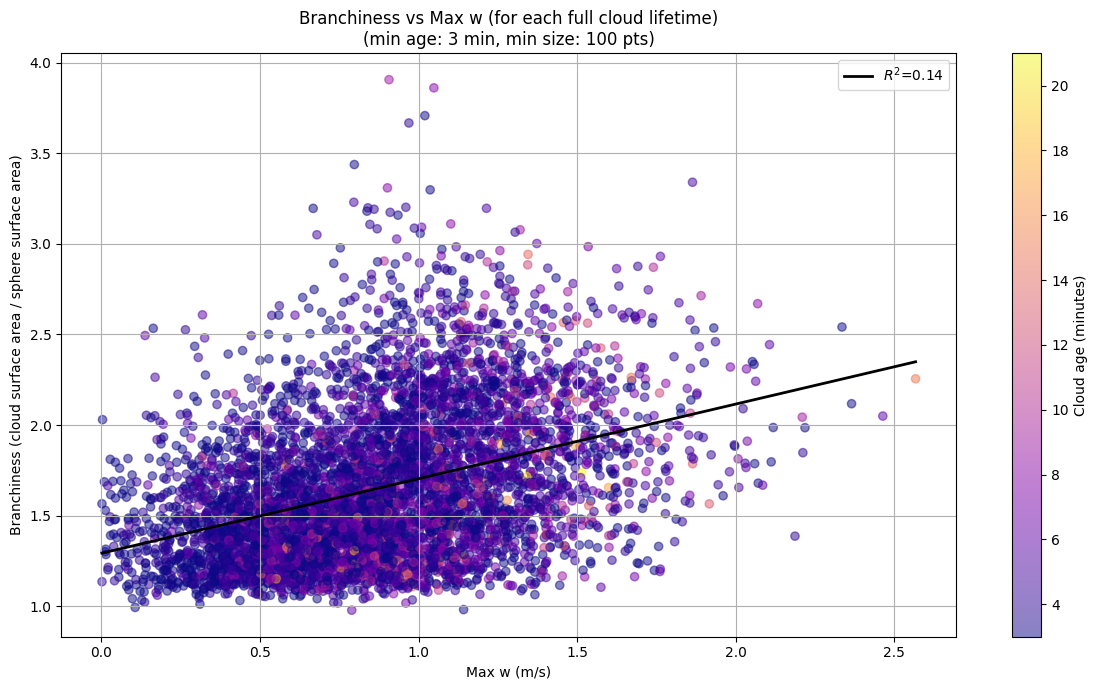

Linear fit: branchiness = 0.412 * max_updraft + 1.292
R^2 = 0.144, p-value = 1.26e-190


In [16]:
def extract_max_updraft_and_branchiness(raw, df_tracks, voxel_dx=25.0, voxel_dy=25.0, voxel_dz=25.0):
    """
    Extracts max updraft (positive vertical velocity) and branchiness for each track.
    Branchiness is defined as max(surface_area) / sphere_surface_area,
    where sphere_surface_area is the surface area of a sphere with the same volume as the cloud.
    """
    w_per_level = raw.get('w_per_level', None)
    surface_area = raw.get('surface_area', None)
    size = raw.get('size', None)
    idx = df_tracks.track_index.values

    # Max updraft per track (ignore negative values)
    if w_per_level is not None and hasattr(w_per_level, 'shape') and len(w_per_level.shape) == 3:
        w_vals = w_per_level[idx, :, :]  # shape: (track, time, level)
        w_vals_pos = np.where(w_vals > 0, w_vals, np.nan)
        max_updraft = np.nanmax(w_vals_pos, axis=(1,2))
    else:
        max_updraft = np.full(len(idx), np.nan)

    # Branchiness: max(surface_area) / sphere_surface_area per track
    if surface_area is not None and size is not None:
        max_surface_area = np.nanmax(surface_area[idx, :], axis=1)
        max_size = np.nanmax(size[idx, :], axis=1)
        voxel_volume = voxel_dx * voxel_dy * voxel_dz
        max_volume = max_size * voxel_volume

        # Surface area of a sphere with same volume: 4 * pi * (3*V/(4*pi))**(2/3)
        sphere_surface_area = 4 * np.pi * np.power(3 * max_volume / (4 * np.pi), 2/3)
        branchiness = max_surface_area / np.where(sphere_surface_area > 0, sphere_surface_area, np.nan)
    else:
        branchiness = np.full(len(idx), np.nan)

    return max_updraft, branchiness

# User parameters
min_age_minutes = 3  # clouds must live at least this many minutes
min_size_points = 100  # clouds must reach at least this many voxels once
dt_seconds = 60       # time step in seconds

max_updraft, branchiness = extract_max_updraft_and_branchiness(
    raw, df_tracks, voxel_dx=25.0, voxel_dy=25.0, voxel_dz=25.0
)
ages = df_tracks.lifetime.values * dt_seconds / 60.0  # convert to minutes
sizes = df_tracks.max_size_points.values

# Filter: valid, positive updraft, min age, min size
valid = (
    np.isfinite(branchiness) &
    np.isfinite(max_updraft) &
    (max_updraft > 0) &
    (ages >= min_age_minutes) &
    (sizes >= min_size_points)
)
from scipy.stats import linregress

plt.figure(figsize=(12,7))
sc = plt.scatter(max_updraft[valid], branchiness[valid], c=ages[valid], cmap='plasma', alpha=0.5)

# Fit a linear regression line (least squares)
slope, intercept, r_value, p_value, std_err = linregress(max_updraft[valid], branchiness[valid])
x_fit = np.linspace(np.nanmin(max_updraft[valid]), np.nanmax(max_updraft[valid]), 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, color='black', lw=2, label=f'$R^2$={r_value**2:.2f}')

plt.xlabel("Max w (m/s)")
plt.ylabel("Branchiness (cloud surface area / sphere surface area)")
plt.title(f"Branchiness vs Max w (for each full cloud lifetime)\n(min age: {min_age_minutes} min, min size: {min_size_points} pts)")
plt.colorbar(sc, label="Cloud age (minutes)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Linear fit: branchiness = {slope:.3f} * max_updraft + {intercept:.3f}")
print(f"R^2 = {r_value**2:.3f}, p-value = {p_value:.3g}")

In [ ]:
#

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_14174/2138383589.py:16: RuntimeWarning: All-NaN slice encountered
  max_updraft = np.nanmax(w_vals_pos, axis=(1,2))


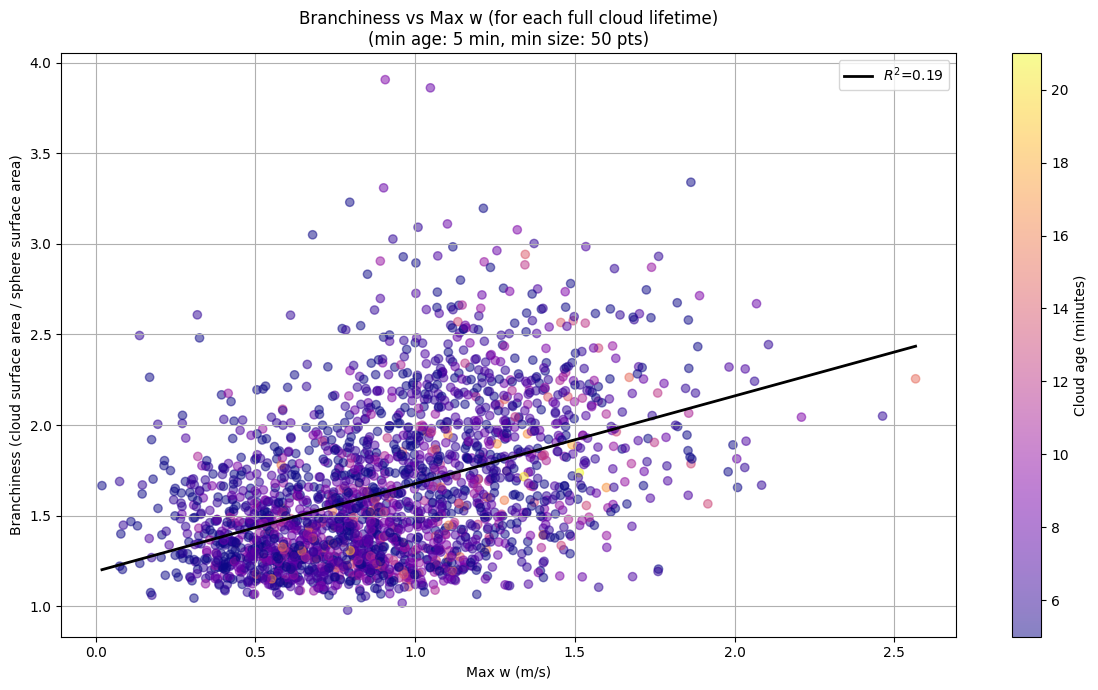

Linear fit: branchiness = 0.484 * max_updraft + 1.192
R^2 = 0.189, p-value = 2.24e-102


In [14]:
def extract_max_updraft_and_branchiness(raw, df_tracks, voxel_dx=25.0, voxel_dy=25.0, voxel_dz=25.0):
    """
    Extracts max updraft (positive vertical velocity) and branchiness for each track.
    Branchiness is defined as max(surface_area) / sphere_surface_area,
    where sphere_surface_area is the surface area of a sphere with the same volume as the cloud.
    """
    w_per_level = raw.get('w_per_level', None)
    surface_area = raw.get('surface_area', None)
    size = raw.get('size', None)
    idx = df_tracks.track_index.values

    # Max updraft per track (ignore negative values)
    if w_per_level is not None and hasattr(w_per_level, 'shape') and len(w_per_level.shape) == 3:
        w_vals = w_per_level[idx, :, :]  # shape: (track, time, level)
        w_vals_pos = np.where(w_vals > 0, w_vals, np.nan)
        max_updraft = np.nanmax(w_vals_pos, axis=(1,2))
    else:
        max_updraft = np.full(len(idx), np.nan)

    # Branchiness: max(surface_area) / sphere_surface_area per track
    if surface_area is not None and size is not None:
        max_surface_area = np.nanmax(surface_area[idx, :], axis=1)
        max_size = np.nanmax(size[idx, :], axis=1)
        voxel_volume = voxel_dx * voxel_dy * voxel_dz
        max_volume = max_size * voxel_volume

        # Surface area of a sphere with same volume: 4 * pi * (3*V/(4*pi))**(2/3)
        sphere_surface_area = 4 * np.pi * np.power(3 * max_volume / (4 * np.pi), 2/3)
        branchiness = max_surface_area / np.where(sphere_surface_area > 0, sphere_surface_area, np.nan)
    else:
        branchiness = np.full(len(idx), np.nan)

    return max_updraft, branchiness

# User parameters
min_age_minutes = 5  # clouds must live at least this many minutes
min_size_points = 50  # clouds must reach at least this many voxels once
dt_seconds = 60       # time step in seconds

max_updraft, branchiness = extract_max_updraft_and_branchiness(
    raw, df_tracks, voxel_dx=25.0, voxel_dy=25.0, voxel_dz=25.0
)

# Use actual age from NetCDF output (max age per cloud)
age_array = raw.get('age', None)
idx = df_tracks.track_index.values
size = raw.get('size', None)

if age_array is not None and hasattr(age_array, 'shape') and len(age_array.shape) == 2 and size is not None:
    # Valid timesteps: where size > 0 and not NaN
    valid_timesteps = (size[idx, :] > 0) & np.isfinite(size[idx, :])
    ages = np.array([
        np.max(age_array[i, valid_timesteps[i]]) if np.any(valid_timesteps[i]) else np.nan
        for i in range(len(idx))
    ])
    # Age starts at 0, so add 1 to get true lifespan in timesteps, then convert to minutes
    ages = (ages + 1) * dt_seconds / 60.0
else:
    ages = df_tracks.lifetime.values * dt_seconds / 60.0  # fallback

sizes = df_tracks.max_size_points.values

# Filter: valid, positive updraft, min age, min size
valid = (
    np.isfinite(branchiness) &
    np.isfinite(max_updraft) &
    (max_updraft > 0) &
    (ages >= min_age_minutes) &
    (sizes >= min_size_points)
)
from scipy.stats import linregress

plt.figure(figsize=(12,7))
sc = plt.scatter(max_updraft[valid], branchiness[valid], c=ages[valid], cmap='plasma', alpha=0.5)

# Fit a linear regression line (least squares)
slope, intercept, r_value, p_value, std_err = linregress(max_updraft[valid], branchiness[valid])
x_fit = np.linspace(np.nanmin(max_updraft[valid]), np.nanmax(max_updraft[valid]), 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, color='black', lw=2, label=f'$R^2$={r_value**2:.2f}')

plt.xlabel("Max w (m/s)")
plt.ylabel("Branchiness (cloud surface area / sphere surface area)")
plt.title(f"Branchiness vs Max w (for each full cloud lifetime)\n(min age: {min_age_minutes} min, min size: {min_size_points} pts)")
plt.colorbar(sc, label="Cloud age (minutes)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Linear fit: branchiness = {slope:.3f} * max_updraft + {intercept:.3f}")
print(f"R^2 = {r_value**2:.3f}, p-value = {p_value:.3g}")

## Simply making the above graph nicer to work better for AGU


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_37547/3529597482.py:16: RuntimeWarning: All-NaN slice encountered
  max_updraft = np.nanmax(w_vals_pos, axis=(1,2))


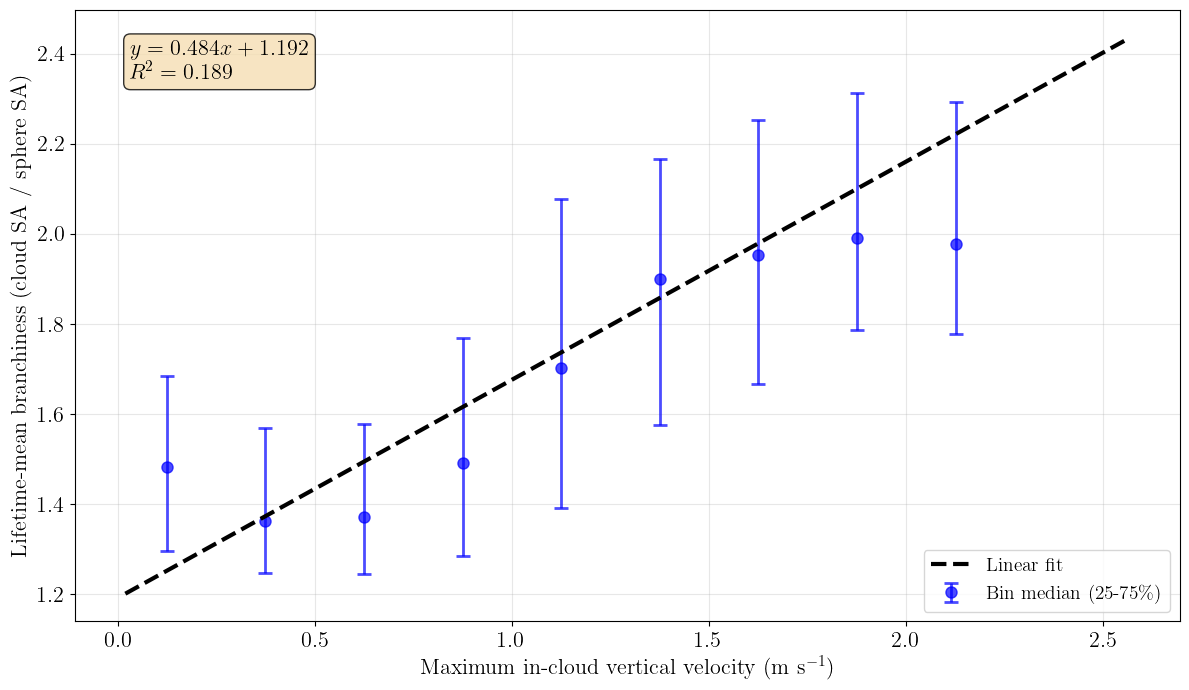

Branchiness vs Max w (binned statistics)
Filters: min age = 5 min, min size = 50 pts
Bin width: 0.25 m/s
Linear fit: branchiness = 0.4843 * max_w + 1.1918
R^2 = 0.1889, p-value = 2.24e-102
Number of clouds: 2207
Number of bins with ≥5 clouds: 9/11
PDF saved as: branchiness_vs_w_binned.pdf


In [48]:
def extract_max_updraft_and_branchiness(raw, df_tracks, voxel_dx=25.0, voxel_dy=25.0, voxel_dz=25.0):
    """
    Extracts max updraft (positive vertical velocity) and branchiness for each track.
    Branchiness is defined as max(surface_area) / sphere_surface_area,
    where sphere_surface_area is the surface area of a sphere with the same volume as the cloud.
    """
    w_per_level = raw.get('w_per_level', None)
    surface_area = raw.get('surface_area', None)
    size = raw.get('size', None)
    idx = df_tracks.track_index.values

    # Max updraft per track (ignore negative values)
    if w_per_level is not None and hasattr(w_per_level, 'shape') and len(w_per_level.shape) == 3:
        w_vals = w_per_level[idx, :, :]  # shape: (track, time, level)
        w_vals_pos = np.where(w_vals > 0, w_vals, np.nan)
        max_updraft = np.nanmax(w_vals_pos, axis=(1,2))
    else:
        max_updraft = np.full(len(idx), np.nan)

    # Branchiness: max(surface_area) / sphere_surface_area per track
    if surface_area is not None and size is not None:
        max_surface_area = np.nanmax(surface_area[idx, :], axis=1)
        max_size = np.nanmax(size[idx, :], axis=1)
        voxel_volume = voxel_dx * voxel_dy * voxel_dz
        max_volume = max_size * voxel_volume

        # Surface area of a sphere with same volume: 4 * pi * (3*V/(4*pi))**(2/3)
        sphere_surface_area = 4 * np.pi * np.power(3 * max_volume / (4 * np.pi), 2/3)
        branchiness = max_surface_area / np.where(sphere_surface_area > 0, sphere_surface_area, np.nan)
    else:
        branchiness = np.full(len(idx), np.nan)

    return max_updraft, branchiness

# User parameters
min_age_minutes = 5  # clouds must live at least this many minutes
min_size_points = 50  # clouds must reach at least this many voxels once
dt_seconds = 60       # time step in seconds
top_percentile_w = None  # Set to a value (e.g., 90) to plot only top percentile of max_w, or None to plot all
bin_width = 0.25  # Bin width for max_w (m/s)

max_updraft, branchiness = extract_max_updraft_and_branchiness(
    raw, df_tracks, voxel_dx=25.0, voxel_dy=25.0, voxel_dz=25.0
)

# Use actual age from NetCDF output (max age per cloud)
age_array = raw.get('age', None)
idx = df_tracks.track_index.values
size = raw.get('size', None)

if age_array is not None and hasattr(age_array, 'shape') and len(age_array.shape) == 2 and size is not None:
    # Valid timesteps: where size > 0 and not NaN
    valid_timesteps = (size[idx, :] > 0) & np.isfinite(size[idx, :])
    ages = np.array([
        np.max(age_array[i, valid_timesteps[i]]) if np.any(valid_timesteps[i]) else np.nan
        for i in range(len(idx))
    ])
    # Age starts at 0, so add 1 to get true lifespan in timesteps, then convert to minutes
    ages = (ages + 1) * dt_seconds / 60.0
else:
    ages = df_tracks.lifetime.values * dt_seconds / 60.0  # fallback

sizes = df_tracks.max_size_points.values

# Filter: valid, positive updraft, min age, min size
valid = (
    np.isfinite(branchiness) &
    np.isfinite(max_updraft) &
    (max_updraft > 0) &
    (ages >= min_age_minutes) &
    (sizes >= min_size_points)
)

# Optional: filter to top percentile of max_w
if top_percentile_w is not None:
    w_threshold = np.nanpercentile(max_updraft[valid], top_percentile_w)
    valid = valid & (max_updraft >= w_threshold)
    print(f"Filtering to top {100-top_percentile_w:.0f}% of clouds by max_w (threshold: {w_threshold:.3f} m/s)")
    print(f"Number of clouds after filtering: {valid.sum()}")

from scipy.stats import linregress

# Enable LaTeX font rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# Perform linear regression on all data
x_data = max_updraft[valid]
y_data = branchiness[valid]
slope, intercept, r_value, p_value, std_err = linregress(x_data, y_data)

# Create bins for max_w
w_min, w_max = np.nanmin(x_data), np.nanmax(x_data)
bins = np.arange(np.floor(w_min / bin_width) * bin_width, 
                 np.ceil(w_max / bin_width) * bin_width + bin_width, 
                 bin_width)

# Compute binned statistics
from scipy.stats import binned_statistic
bin_medians, bin_edges, _ = binned_statistic(x_data, y_data, statistic='median', bins=bins)
bin_means, _, _ = binned_statistic(x_data, y_data, statistic='mean', bins=bins)
bin_p25, _, _ = binned_statistic(x_data, y_data, statistic=lambda x: np.percentile(x, 25), bins=bins)
bin_p75, _, _ = binned_statistic(x_data, y_data, statistic=lambda x: np.percentile(x, 75), bins=bins)
bin_counts, _, _ = binned_statistic(x_data, y_data, statistic='count', bins=bins)

# Bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Filter bins with at least 5 points
valid_bins = bin_counts >= 5

# Generate regression line
x_fit = np.linspace(w_min, w_max, 100)
y_fit = slope * x_fit + intercept

# Create the plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot binned statistics with error bars
ax.errorbar(bin_centers[valid_bins], bin_medians[valid_bins], 
            yerr=[bin_medians[valid_bins] - bin_p25[valid_bins], 
                  bin_p75[valid_bins] - bin_medians[valid_bins]],
            fmt='o', color='blue', markersize=8, capsize=5, capthick=2,
            elinewidth=2, alpha=0.7, label='Bin median (25-75\\%)')

# Plot regression line
ax.plot(x_fit, y_fit, color='black', lw=3, linestyle='--', 
       label=f'Linear fit', zorder=10)

# Add text box with regression info
textstr = f'$y = {slope:.3f}x + {intercept:.3f}$\n$R^2 = {r_value**2:.3f}$'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=props)

ax.set_xlabel(r'Maximum in-cloud vertical velocity (m s$^{-1}$)', fontsize=16)
ax.set_ylabel(r'Lifetime-mean branchiness (cloud SA / sphere SA)', fontsize=16)
ax.tick_params(labelsize=16)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=14, loc='lower right')
plt.tight_layout()

# Save as PDF
plt.savefig('branchiness_vs_w_binned.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print(f"Branchiness vs Max w (binned statistics)")
print(f"Filters: min age = {min_age_minutes} min, min size = {min_size_points} pts")
if top_percentile_w is not None:
    print(f"         top {100-top_percentile_w:.0f}% by max_w")
print(f"Bin width: {bin_width} m/s")
print(f"Linear fit: branchiness = {slope:.4f} * max_w + {intercept:.4f}")
print(f"R^2 = {r_value**2:.4f}, p-value = {p_value:.3g}")
print(f"Number of clouds: {len(x_data)}")
print(f"Number of bins with ≥5 clouds: {valid_bins.sum()}/{len(bins)-1}")
print(f"PDF saved as: branchiness_vs_w_binned.pdf")

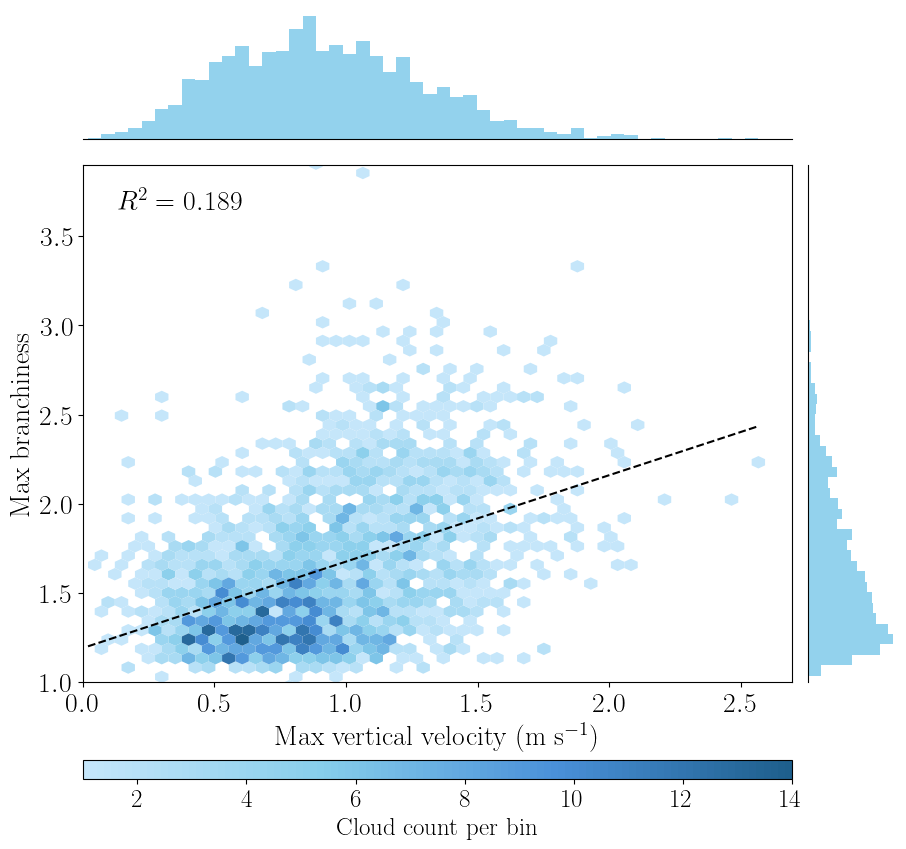

PDF saved as: branchiness_vs_w_hexbin.pdf


In [ ]:
## 2D Hexbin density plot with regression line and marginal distributions

# Enable LaTeX font rendering (if not already enabled)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 20

# Create figure with GridSpec for marginal distributions
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap

# Define custom skyblue colormap: light skyblue to dark blue
# This creates a proper gradient from light to dark
colors_map = [
    '#C5E6FA',  # Light skyblue (minimum - slightly darker, more visible)
    '#87CEEB',  # Standard skyblue (medium)
    '#4A90D9',  # Medium-dark blue
    '#1E5F8C'   # Dark blue (maximum)
]
n_bins = 100
cmap = LinearSegmentedColormap.from_list('skyblue_gradient', colors_map, N=n_bins)

fig = plt.figure(figsize=(13, 10))
gs = GridSpec(4, 3, figure=fig, width_ratios=[1, 4, 0.5], height_ratios=[1, 4, 0.2, 0.15],
              hspace=0.15, wspace=0.05)

# Main hexbin plot
ax_main = fig.add_subplot(gs[1, 1])
hexbin = ax_main.hexbin(x_data, y_data, gridsize=50, cmap=cmap, 
                        mincnt=1, edgecolors='none', alpha=1.0)

# Plot regression line
x_fit = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
y_fit = slope * x_fit + intercept
ax_main.plot(x_fit, y_fit, color='black', lw=1.5, linestyle='--', zorder=10)

# Add text box with R² only
textstr = f'$R^2 = {r_value**2:.3f}$'
ax_main.text(0.05, 0.95, textstr, transform=ax_main.transAxes, fontsize=20,
             verticalalignment='top', color='black')

ax_main.set_xlabel(r'Max vertical velocity (m s$^{-1}$)', fontsize=20)
ax_main.set_ylabel(r'Max branchiness', fontsize=20)
ax_main.tick_params(labelsize=20)

# Set axis limits: x starts at 0, y starts at 1
ax_main.set_xlim(left=0)
ax_main.set_ylim(bottom=1)
ax_main.set_ylim(top=3.9)

# Top marginal histogram (x-axis distribution) - skyblue, no edges, no ticks, no grid
ax_top = fig.add_subplot(gs[0, 1], sharex=ax_main)
ax_top.hist(x_data, bins=50, color='skyblue', edgecolor='none', alpha=0.9)
ax_top.tick_params(labelsize=18, labelbottom=False, labelleft=False, left=False, 
                   bottom=False, top=False, right=False)
ax_top.spines['top'].set_visible(False)
ax_top.spines['right'].set_visible(False)
ax_top.spines['left'].set_visible(False)
ax_top.spines['bottom']

# Right marginal histogram (y-axis distribution) - skyblue, no edges, no ticks, no grid
ax_right = fig.add_subplot(gs[1, 2], sharey=ax_main)
ax_right.hist(y_data, bins=50, orientation='horizontal', color='skyblue', 
             edgecolor='none', alpha=0.9)
ax_right.tick_params(labelsize=18, labelbottom=False, labelleft=False, 
                     bottom=False, top=False, right=False, left=False)
ax_right.spines['top'].set_visible(False)
ax_right.spines['right'].set_visible(False)
ax_right.spines['left']
ax_right.spines['bottom'].set_visible(False)

# Add colorbar in row below main plot
ax_cbar = fig.add_subplot(gs[3, 1])
cbar = plt.colorbar(hexbin, cax=ax_cbar, orientation='horizontal')
cbar.ax.tick_params(labelsize=18)
cbar.set_label('Cloud count per bin', fontsize=18)

# Save as PDF with transparent background
plt.savefig('branchiness_vs_w_hexbin.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

print(f"PDF saved as: branchiness_vs_w_hexbin.pdf (transparent background)")


## For AGU (start)
The following few cells investigate the statement: "Cloud branchiness increases with vertical velocity, expanding cloud-environment contact area and potential for mixing, hence impacting the vertical development of structures."

Requiring two plots:
1. Branchiness vs vertical velocity (some of it above but want to be more specific)
2. Branchiness vs vertical development / persistence

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_37547/3811489303.py:64: RuntimeWarning: All-NaN slice encountered
  max_w = np.nanmax(w_pos, axis=2)  # (track, time)


High-w threshold (top 10% of clouds): 1.404 m/s
Number of valid clouds: 2269 / 41398
Number of high-w clouds: 227
Number of control clouds: 2042

BEFORE/AFTER ANALYSIS MODE
Comparing branchiness 3 min before vs 3 min after peak-w
(Timestep offset: 3)

High-w clouds with complete before/after data: 37
Control clouds with complete before/after data: 180


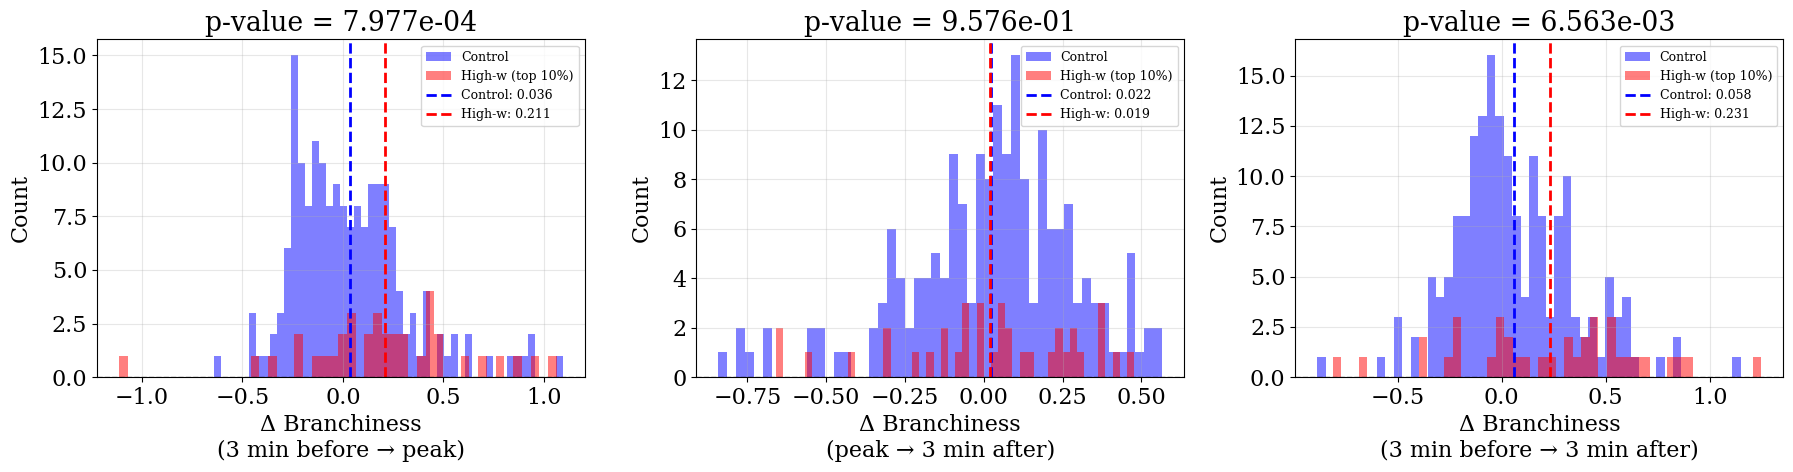

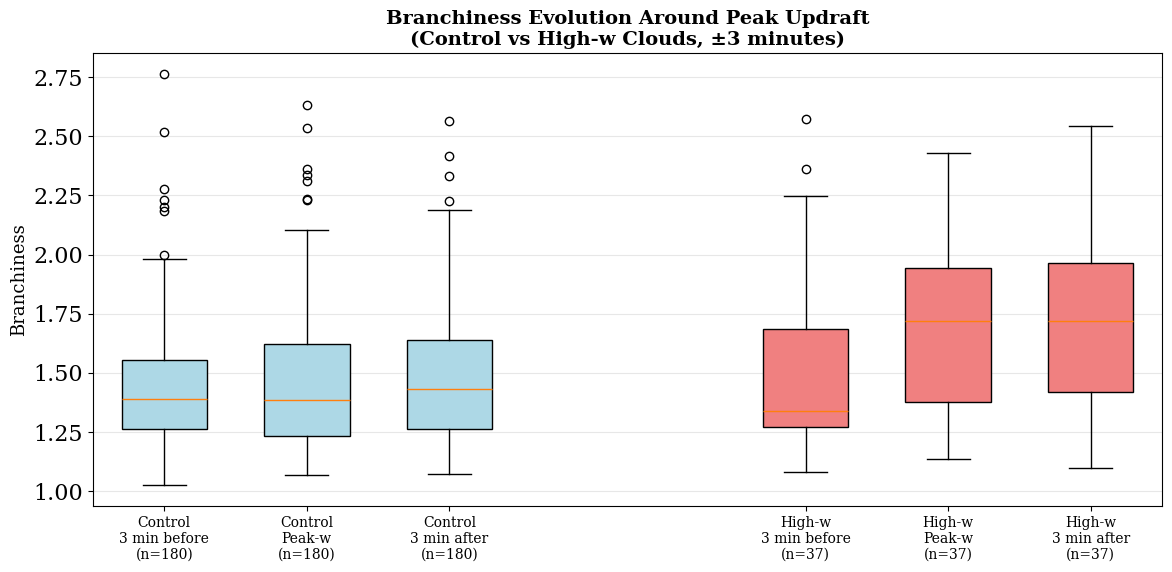

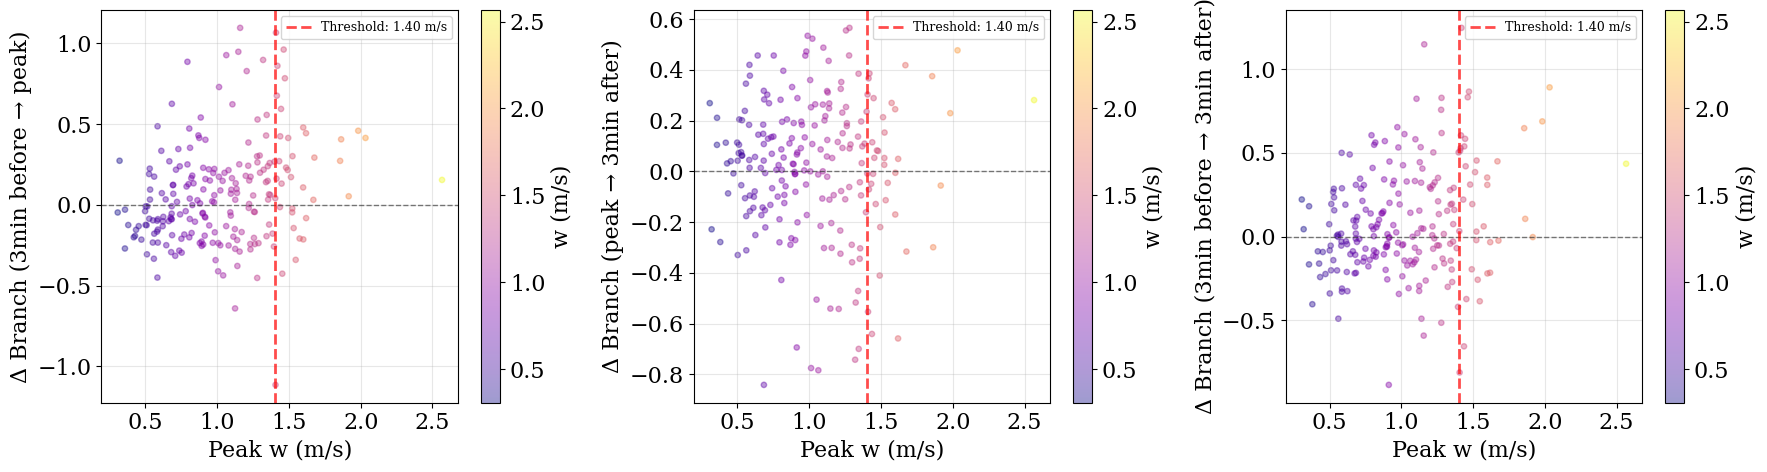


STATISTICAL SUMMARY: Before/After Peak-w Analysis
Comparing 3 minutes before vs after peak updraft

Control clouds (n=180):
  Branchiness 3 min before peak: 1.4317 ± 0.2652
  Branchiness at peak-w:                 1.4679 ± 0.3040
  Branchiness 3 min after peak:  1.4899 ± 0.2880
  Change (before → peak):   0.0361 ± 0.2886
  Change (peak → after):    0.0220 ± 0.2716
  Change (before → after):  0.0581 ± 0.2910

High-w (top 10%) clouds (n=37):
  Branchiness 3 min before peak: 1.5110 ± 0.3768
  Branchiness at peak-w:                 1.7225 ± 0.3607
  Branchiness 3 min after peak:  1.7416 ± 0.3956
  Change (before → peak):   0.2114 ± 0.4115
  Change (peak → after):    0.0191 ± 0.2881
  Change (before → after):  0.2306 ± 0.4467

----------------------------------------------------------------------
High-w vs Control Comparison:

  3 min before → peak:
    Mann-Whitney U: p = 7.9770e-04
    T-test: p = 2.1412e-03
    ✓ Significant: High-w shows greater change (+0.1753)

  peak → 3 min after:


In [61]:
from matplotlib import rc
rc('text', usetex=False) 


## ============================================================================
## TEMPORAL LAG ANALYSIS: Two Modes
## ============================================================================
##
## MODE 1 (LAGGED): Does High W at Time N Increase Branchiness at N+1, N+2, N+3?
##   - Compares branchiness change from peak-w moment to 1, 2, 3 minutes later
##   - Tests if strong updrafts have a delayed effect on cloud structure
##   - Set COMPARE_BEFORE_AFTER = False
##
## MODE 2 (BEFORE/AFTER): Does Branchiness Change Around Peak-w?
##   - Compares branchiness X minutes BEFORE vs AFTER peak-w moment
##   - Tests if clouds systematically become more branchy around peak updraft
##   - Set COMPARE_BEFORE_AFTER = True and adjust MINUTES_BEFORE_AFTER
##   - Example: MINUTES_BEFORE_AFTER=3 compares branch(t-3) vs branch(t+3)
##
## This cell is standalone - requires raw and df_tracks from Cell 1
## ============================================================================

from scipy.stats import mannwhitneyu, ttest_ind, linregress

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def compute_branchiness_timeseries(raw, voxel_dx=25.0, voxel_dy=25.0, voxel_dz=25.0):
    """
    Compute branchiness at each timestep for each track.
    Returns: branchiness array of shape (n_tracks, n_timesteps)
    """
    surface_area = raw.get('surface_area', None)  # (track, time)
    size = raw.get('size', None)  # (track, time) in voxels
    
    if surface_area is None or size is None:
        return None
    
    voxel_volume = voxel_dx * voxel_dy * voxel_dz
    volume = size * voxel_volume  # (track, time)
    
    # Surface area of equivalent sphere: 4π(3V/4π)^(2/3)
    sphere_surface_area = 4 * np.pi * np.power(3 * volume / (4 * np.pi), 2/3)
    
    # Branchiness: actual surface area / sphere surface area
    branchiness = surface_area / np.where(sphere_surface_area > 0, sphere_surface_area, np.nan)
    
    return branchiness


def compute_max_w_timeseries(raw):
    """
    Compute max vertical velocity at each timestep for each track.
    Returns: max_w array of shape (n_tracks, n_timesteps)
    """
    w_per_level = raw.get('w_per_level', None)  # (track, time, level)
    
    if w_per_level is None:
        return None
    
    # Max w across all levels at each timestep (only positive values)
    w_pos = np.where(w_per_level > 0, w_per_level, np.nan)
    max_w = np.nanmax(w_pos, axis=2)  # (track, time)
    
    return max_w


def analyze_lagged_branchiness(raw, df_tracks, lag_timesteps=[1, 2, 3], 
                                percentile_threshold=90, min_age_minutes=5, 
                                min_size_points=50, dt_seconds=60,
                                voxel_dx=25.0, voxel_dy=25.0, voxel_dz=25.0,
                                compare_before_after=False, minutes_before_after=3):
    """
    Analyze how high-w clouds (by max w) affect branchiness at N+lag.
    Now selects clouds by their maximum w value (one event per cloud).
    
    Parameters:
    -----------
    raw : dict
        Dictionary containing NetCDF variables
    df_tracks : DataFrame
        Track metadata
    lag_timesteps : list
        List of lag timesteps to analyze (e.g., [1, 2, 3])
    percentile_threshold : float
        Percentile threshold for "high-w" clouds (e.g., 90 = top 10% of clouds)
    min_age_minutes : float
        Minimum cloud lifetime to include
    min_size_points : int
        Minimum cloud size to include
    dt_seconds : int
        Timestep duration in seconds
    compare_before_after : bool
        If True, compare branchiness X minutes before vs after peak-w (instead of lagged analysis)
    minutes_before_after : int
        If compare_before_after=True, number of minutes before/after peak-w to compare
        
    Returns:
    --------
    results : dict
        Dictionary containing analysis results
    """
    
    # Compute time series
    branchiness = compute_branchiness_timeseries(raw, voxel_dx, voxel_dy, voxel_dz)
    max_w = compute_max_w_timeseries(raw)
    size = raw.get('size', None)
    age_array = raw.get('age', None)
    
    if branchiness is None or max_w is None or size is None:
        print("Missing required data!")
        return None
    
    idx = df_tracks.track_index.values
    branchiness = branchiness[idx, :]
    max_w = max_w[idx, :]
    size = size[idx, :]
    
    # Calculate cloud lifetimes and max sizes
    if age_array is not None:
        age_array = age_array[idx, :]
        valid_timesteps = (size > 0) & np.isfinite(size)
        ages = np.array([
            np.max(age_array[i, valid_timesteps[i]]) if np.any(valid_timesteps[i]) else np.nan
            for i in range(len(idx))
        ])
        ages = (ages + 1) * dt_seconds / 60.0
    else:
        ages = df_tracks.lifetime.values * dt_seconds / 60.0
    
    max_sizes = np.nanmax(size, axis=1)
    
    # Filter tracks by age and size
    valid_tracks = (ages >= min_age_minutes) & (max_sizes >= min_size_points)
    
    # NEW APPROACH: Find max w per cloud and select top clouds
    n_tracks, n_time = size.shape
    
    # For each valid cloud, find its maximum w value across all timesteps
    cloud_max_w = np.full(n_tracks, np.nan)
    cloud_max_w_timestep = np.full(n_tracks, -1, dtype=int)
    
    for i in range(n_tracks):
        if not valid_tracks[i]:
            continue
        
        # Get valid timesteps for this cloud
        valid_mask = (size[i, :] > 0) & np.isfinite(size[i, :]) & np.isfinite(max_w[i, :]) & np.isfinite(branchiness[i, :])
        if not np.any(valid_mask):
            continue
        
        # Find timestep with maximum w
        valid_w = max_w[i, valid_mask]
        valid_timesteps_idx = np.where(valid_mask)[0]
        max_w_idx = np.argmax(valid_w)
        
        cloud_max_w[i] = valid_w[max_w_idx]
        cloud_max_w_timestep[i] = valid_timesteps_idx[max_w_idx]
    
    # Determine threshold based on cloud max w values
    valid_cloud_w = cloud_max_w[np.isfinite(cloud_max_w)]
    w_threshold = np.nanpercentile(valid_cloud_w, percentile_threshold)
    
    # Identify high-w clouds
    high_w_clouds = (cloud_max_w >= w_threshold) & np.isfinite(cloud_max_w)
    
    print(f"High-w threshold (top {100-percentile_threshold}% of clouds): {w_threshold:.3f} m/s")
    print(f"Number of valid clouds: {valid_tracks.sum()} / {len(valid_tracks)}")
    print(f"Number of high-w clouds: {high_w_clouds.sum()}")
    print(f"Number of control clouds: {(valid_tracks & ~high_w_clouds).sum()}")
    
    # ========================================================================
    # BEFORE/AFTER COMPARISON MODE
    # ========================================================================
    if compare_before_after:
        timesteps_offset = int(minutes_before_after * 60 / dt_seconds)
        
        print(f"\n{'='*70}")
        print(f"BEFORE/AFTER ANALYSIS MODE")
        print(f"Comparing branchiness {minutes_before_after} min before vs {minutes_before_after} min after peak-w")
        print(f"(Timestep offset: {timesteps_offset})")
        print(f"{'='*70}\n")
        
        high_w_events = []
        control_events = []
        
        for i in range(n_tracks):
            if not valid_tracks[i]:
                continue
            
            t = cloud_max_w_timestep[i]
            
            # Need data at t-offset, t (peak), and t+offset
            if t < timesteps_offset or t + timesteps_offset >= n_time:
                continue
            
            t_before = t - timesteps_offset
            t_after = t + timesteps_offset
            
            # Check all three timesteps are valid
            if not all([
                (size[i, t_before] > 0) and np.isfinite(branchiness[i, t_before]),
                (size[i, t] > 0) and np.isfinite(branchiness[i, t]),
                (size[i, t_after] > 0) and np.isfinite(branchiness[i, t_after])
            ]):
                continue
            
            w_peak = max_w[i, t]
            branch_before = branchiness[i, t_before]
            branch_peak = branchiness[i, t]
            branch_after = branchiness[i, t_after]
            
            if not all(np.isfinite([w_peak, branch_before, branch_peak, branch_after])):
                continue
            
            # Calculate changes
            change_before_to_peak = branch_peak - branch_before
            change_peak_to_after = branch_after - branch_peak
            change_before_to_after = branch_after - branch_before
            
            event_data = {
                'track': i,
                'timestep_peak': t,
                'w_peak': w_peak,
                'branch_before': branch_before,
                'branch_peak': branch_peak,
                'branch_after': branch_after,
                'change_before_to_peak': change_before_to_peak,
                'change_peak_to_after': change_peak_to_after,
                'change_before_to_after': change_before_to_after
            }
            
            if high_w_clouds[i]:
                high_w_events.append(event_data)
            else:
                control_events.append(event_data)
        
        results = {
            'w_threshold': w_threshold,
            'mode': 'before_after',
            'minutes_offset': minutes_before_after,
            'timesteps_offset': timesteps_offset,
            'before_after_data': {
                'high_w': pd.DataFrame(high_w_events),
                'control': pd.DataFrame(control_events)
            }
        }
        
        print(f"High-w clouds with complete before/after data: {len(high_w_events)}")
        print(f"Control clouds with complete before/after data: {len(control_events)}")
        
        return results
    
    # ========================================================================
    # ORIGINAL LAGGED ANALYSIS MODE
    # ========================================================================
    # Collect lagged branchiness data (ONE DATA POINT PER CLOUD)
    results = {
        'w_threshold': w_threshold,
        'mode': 'lagged',
        'lag_data': {}
    }
    
    for lag in lag_timesteps:
        high_w_events = []
        control_events = []
        
        for i in range(n_tracks):
            if not valid_tracks[i]:
                continue
            
            t = cloud_max_w_timestep[i]
            if t < 0 or t + lag >= n_time:
                continue
            
            # Check if future timestep is valid
            if not ((size[i, t + lag] > 0) and np.isfinite(branchiness[i, t + lag])):
                continue
            
            w_peak = max_w[i, t]
            branch_current = branchiness[i, t]
            branch_future = branchiness[i, t + lag]
            
            if not (np.isfinite(w_peak) and np.isfinite(branch_current) and np.isfinite(branch_future)):
                continue
            
            # Calculate branchiness change
            branch_change = branch_future - branch_current
            
            # Categorize cloud
            event_data = {
                'track': i,
                'timestep': t,
                'w': w_peak,
                'branch_current': branch_current,
                'branch_future': branch_future,
                'branch_change': branch_change
            }
            
            if high_w_clouds[i]:
                high_w_events.append(event_data)
            else:
                control_events.append(event_data)
        
        results['lag_data'][lag] = {
            'high_w': pd.DataFrame(high_w_events),
            'control': pd.DataFrame(control_events)
        }
        
        print(f"\nLag = {lag} timestep(s) ({lag * dt_seconds / 60:.1f} min):")
        print(f"  High-w clouds with data: {len(high_w_events)}")
        print(f"  Control clouds with data: {len(control_events)}")
    
    return results


# ============================================================================
# RUN ANALYSIS
# ============================================================================

# CHOOSE ANALYSIS MODE:
# Set compare_before_after=False for original lagged analysis (1, 2, 3 min after peak)
# Set compare_before_after=True to compare X minutes before vs after peak-w

COMPARE_BEFORE_AFTER = True  # Toggle this!
MINUTES_BEFORE_AFTER = 3     # Adjust this! (used if COMPARE_BEFORE_AFTER=True)

# Run the analysis
lag_results = analyze_lagged_branchiness(
    raw, df_tracks,
    lag_timesteps=[1, 2, 3],
    percentile_threshold=90,
    min_age_minutes=5,
    min_size_points=10,
    dt_seconds=60,
    voxel_dx=25.0,
    voxel_dy=25.0,
    voxel_dz=25.0,
    compare_before_after=COMPARE_BEFORE_AFTER,
    minutes_before_after=MINUTES_BEFORE_AFTER
)

# ============================================================================
# VISUALIZATIONS (MODE-DEPENDENT)
# ============================================================================

if lag_results['mode'] == 'before_after':
    # ========================================================================
    # BEFORE/AFTER MODE VISUALIZATIONS
    # ========================================================================
    
    df_high = lag_results['before_after_data']['high_w']
    df_control = lag_results['before_after_data']['control']
    minutes = lag_results['minutes_offset']
    
    # ------------------------------------------------------------------------
    # VIZ 1: Histograms of branchiness changes
    # ------------------------------------------------------------------------
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for ax, metric, label in zip(
        axes,
        ['change_before_to_peak', 'change_peak_to_after', 'change_before_to_after'],
        [f'Δ Branchiness\n({minutes} min before → peak)',
         f'Δ Branchiness\n(peak → {minutes} min after)',
         f'Δ Branchiness\n({minutes} min before → {minutes} min after)']
    ):
        if not df_high.empty and not df_control.empty:
            ax.hist(df_control[metric], bins=50, alpha=0.5, label='Control', color='blue')
            ax.hist(df_high[metric], bins=50, alpha=0.5, label='High-w (top 10%)', color='red')
            
            mean_control = df_control[metric].mean()
            mean_high = df_high[metric].mean()
            ax.axvline(mean_control, color='blue', linestyle='--', linewidth=2, 
                      label=f'Control: {mean_control:.3f}')
            ax.axvline(mean_high, color='red', linestyle='--', linewidth=2, 
                      label=f'High-w: {mean_high:.3f}')
            
            # Statistical test
            statistic, p_value = mannwhitneyu(df_high[metric], df_control[metric], 
                                              alternative='two-sided')
            
            ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
            ax.set_xlabel(label)
            ax.set_ylabel('Count')
            ax.set_title(f'p-value = {p_value:.3e}')
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ------------------------------------------------------------------------
    # VIZ 2: Box plots comparing before/peak/after (combined plot)
    # ------------------------------------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    if not df_control.empty and not df_high.empty:
        # Prepare data for combined box plot
        data_for_box = []
        labels = []
        colors = []
        
        # Control clouds
        data_for_box.extend([
            df_control['branch_before'].values,
            df_control['branch_peak'].values,
            df_control['branch_after'].values
        ])
        labels.extend([
            f'Control\n{minutes} min before\n(n={len(df_control)})',
            f'Control\nPeak-w\n(n={len(df_control)})',
            f'Control\n{minutes} min after\n(n={len(df_control)})'
        ])
        colors.extend(['lightblue', 'lightblue', 'lightblue'])
        
        # Add gap position (empty data)
        data_for_box.append([])
        labels.append('')
        colors.append('white')
        
        # High-w clouds
        data_for_box.extend([
            df_high['branch_before'].values,
            df_high['branch_peak'].values,
            df_high['branch_after'].values
        ])
        labels.extend([
            f'High-w\n{minutes} min before\n(n={len(df_high)})',
            f'High-w\nPeak-w\n(n={len(df_high)})',
            f'High-w\n{minutes} min after\n(n={len(df_high)})'
        ])
        colors.extend(['lightcoral', 'lightcoral', 'lightcoral'])
        
        # Create positions for boxes (with gap)
        positions = [1, 2, 3, 4.5, 5.5, 6.5, 7.5]
        
        # Remove empty data from plotting
        plot_data = [d for d in data_for_box if len(d) > 0]
        plot_positions = [p for i, p in enumerate(positions) if len(data_for_box[i]) > 0]
        plot_labels = [l for i, l in enumerate(labels) if len(data_for_box[i]) > 0]
        plot_colors = [c for i, c in enumerate(colors) if len(data_for_box[i]) > 0]
        
        bp = ax.boxplot(plot_data, positions=plot_positions, labels=plot_labels, 
                       patch_artist=True, widths=0.6)
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], plot_colors):
            patch.set_facecolor(color)
        
        ax.set_ylabel('Branchiness', fontsize=13)
        ax.set_title(f'Branchiness Evolution Around Peak Updraft\n(Control vs High-w Clouds, ±{minutes} minutes)', 
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        plt.xticks(rotation=0, fontsize=10)
        
    else:
        ax.text(0.5, 0.5, 'Insufficient data', ha='center', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # ------------------------------------------------------------------------
    # VIZ 3: Scatter plots - w_peak vs branchiness changes
    # ------------------------------------------------------------------------
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for ax, metric, ylabel in zip(
        axes,
        ['change_before_to_peak', 'change_peak_to_after', 'change_before_to_after'],
        [f'Δ Branch ({minutes}min before → peak)',
         f'Δ Branch (peak → {minutes}min after)',
         f'Δ Branch ({minutes}min before → {minutes}min after)']
    ):
        df_all = pd.concat([df_control, df_high], ignore_index=True)
        
        if not df_all.empty:
            sc = ax.scatter(df_all['w_peak'], df_all[metric], 
                          c=df_all['w_peak'], cmap='plasma', alpha=0.4, s=15)
            
            ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
            ax.axvline(lag_results['w_threshold'], color='red', linestyle='--', 
                      linewidth=2, alpha=0.7, label=f"Threshold: {lag_results['w_threshold']:.2f} m/s")
            
            ax.set_xlabel('Peak w (m/s)')
            ax.set_ylabel(ylabel)
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
            plt.colorbar(sc, ax=ax, label='w (m/s)')
    
    plt.tight_layout()
    plt.show()
    
    # ------------------------------------------------------------------------
    # STATISTICAL SUMMARY
    # ------------------------------------------------------------------------
    print("\n" + "="*70)
    print("STATISTICAL SUMMARY: Before/After Peak-w Analysis")
    print(f"Comparing {minutes} minutes before vs after peak updraft")
    print("="*70)
    
    for group_name, df in [('Control', df_control), ('High-w (top 10%)', df_high)]:
        if df.empty:
            continue
        
        print(f"\n{group_name} clouds (n={len(df)}):")
        print(f"  Branchiness {minutes} min before peak: {df['branch_before'].mean():.4f} ± {df['branch_before'].std():.4f}")
        print(f"  Branchiness at peak-w:                 {df['branch_peak'].mean():.4f} ± {df['branch_peak'].std():.4f}")
        print(f"  Branchiness {minutes} min after peak:  {df['branch_after'].mean():.4f} ± {df['branch_after'].std():.4f}")
        print(f"  Change (before → peak):   {df['change_before_to_peak'].mean():.4f} ± {df['change_before_to_peak'].std():.4f}")
        print(f"  Change (peak → after):    {df['change_peak_to_after'].mean():.4f} ± {df['change_peak_to_after'].std():.4f}")
        print(f"  Change (before → after):  {df['change_before_to_after'].mean():.4f} ± {df['change_before_to_after'].std():.4f}")
    
    # Compare high-w vs control
    if not df_high.empty and not df_control.empty:
        print("\n" + "-"*70)
        print("High-w vs Control Comparison:")
        
        for metric, label in [
            ('change_before_to_peak', f'{minutes} min before → peak'),
            ('change_peak_to_after', f'peak → {minutes} min after'),
            ('change_before_to_after', f'{minutes} min before → {minutes} min after')
        ]:
            stat_mw, p_mw = mannwhitneyu(df_high[metric], df_control[metric], alternative='two-sided')
            stat_t, p_t = ttest_ind(df_high[metric], df_control[metric])
            
            print(f"\n  {label}:")
            print(f"    Mann-Whitney U: p = {p_mw:.4e}")
            print(f"    T-test: p = {p_t:.4e}")
            
            if p_mw < 0.05:
                mean_diff = df_high[metric].mean() - df_control[metric].mean()
                direction = "greater" if mean_diff > 0 else "smaller"
                print(f"    ✓ Significant: High-w shows {direction} change ({mean_diff:+.4f})")
            else:
                print(f"    ✗ Not significant at α=0.05")

else:
    # ========================================================================
    # ORIGINAL LAGGED MODE VISUALIZATIONS
    # ========================================================================
    
    # VISUALIZATION 1: Distribution Histograms
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, lag in enumerate([1, 2, 3]):
        ax = axes[i]
        
        df_high = lag_results['lag_data'][lag]['high_w']
        df_control = lag_results['lag_data'][lag]['control']
        
        if not df_high.empty and not df_control.empty:
            # Plot distributions (COUNT histograms, not density)
            ax.hist(df_control['branch_change'], bins=50, alpha=0.5, label='Control clouds', 
                    color='blue')
            ax.hist(df_high['branch_change'], bins=50, alpha=0.5, label=f'High-w clouds (top 10%)', 
                    color='red')
            
            # Add mean lines
            mean_control = df_control['branch_change'].mean()
            mean_high = df_high['branch_change'].mean()
            ax.axvline(mean_control, color='blue', linestyle='--', linewidth=2, label=f'Control mean: {mean_control:.3f}')
            ax.axvline(mean_high, color='red', linestyle='--', linewidth=2, label=f'High-w mean: {mean_high:.3f}')
            
            # Statistical test
            statistic, p_value = mannwhitneyu(df_high['branch_change'], df_control['branch_change'], 
                                              alternative='greater')
            
            ax.set_xlabel('Δ Branchiness (future - current)')
            ax.set_ylabel('Count')
            ax.set_title(f'Lag = {lag} timestep ({lag} min)\np-value = {p_value:.3e}')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'Insufficient data', ha='center', va='center', transform=ax.transAxes)

    plt.tight_layout()
    plt.show()

    # STATISTICAL SUMMARY
    print("\n" + "="*70)
    print("STATISTICAL SUMMARY: High-w vs Control")
    print("="*70)

    for lag in [1, 2, 3]:
        df_high = lag_results['lag_data'][lag]['high_w']
        df_control = lag_results['lag_data'][lag]['control']
        
        if not df_high.empty and not df_control.empty:
            print(f"\nLag = {lag} timestep(s) ({lag} min):")
            print(f"  High-w events (n={len(df_high)}):")
            print(f"    Mean Δ branchiness: {df_high['branch_change'].mean():.4f}")
            print(f"    Median Δ branchiness: {df_high['branch_change'].median():.4f}")
            print(f"    Std Δ branchiness: {df_high['branch_change'].std():.4f}")
            
            print(f"  Control events (n={len(df_control)}):")
            print(f"    Mean Δ branchiness: {df_control['branch_change'].mean():.4f}")
            print(f"    Median Δ branchiness: {df_control['branch_change'].median():.4f}")
            print(f"    Std Δ branchiness: {df_control['branch_change'].std():.4f}")
            
            # Mann-Whitney U test (non-parametric, tests if high-w has higher values)
            stat_mw, p_mw = mannwhitneyu(df_high['branch_change'], df_control['branch_change'], 
                                         alternative='greater')
            
            # Two-sample t-test (parametric)
            stat_t, p_t = ttest_ind(df_high['branch_change'], df_control['branch_change'])
            
            print(f"  Mann-Whitney U test (one-sided): p = {p_mw:.4e}")
            print(f"  T-test (two-sided): p = {p_t:.4e}")
            
            if p_mw < 0.05:
                print(f"  ✓ Significant: High-w events show greater branchiness increase")
            else:
                print(f"  ✗ Not significant at α=0.05")

    # VISUALIZATION 2: Scatter Plots (w vs Δ Branchiness)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, lag in enumerate([1, 2, 3]):
        ax = axes[i]
        
        df_high = lag_results['lag_data'][lag]['high_w']
        df_control = lag_results['lag_data'][lag]['control']
        
        # Combine all events
        df_all = pd.concat([df_control, df_high], ignore_index=True)
        
        if not df_all.empty:
            # Scatter plot with color intensity based on w
            sc = ax.scatter(df_all['w'], df_all['branch_change'], 
                           c=df_all['w'], cmap='plasma', alpha=0.3, s=10)
            
            # Add horizontal line at zero change
            ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
            
            # Mark the high-w threshold
            w_threshold = lag_results['w_threshold']
            ax.axvline(w_threshold, color='red', linestyle='--', linewidth=2, alpha=0.7,
                      label=f'High-w threshold: {w_threshold:.2f} m/s')
            
            ax.set_xlabel('Max w (m/s)')
            ax.set_ylabel('Δ Branchiness (future - current)')
            ax.set_title(f'Lag = {lag} timestep ({lag} min)')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
            plt.colorbar(sc, ax=ax, label='w (m/s)')
        else:
            ax.text(0.5, 0.5, 'Insufficient data', ha='center', va='center', transform=ax.transAxes)

    plt.tight_layout()
    plt.show()

    # VISUALIZATION 3: Box Plots
    fig, ax = plt.subplots(figsize=(12, 6))

    data_for_box = []
    labels_for_box = []
    positions = []

    pos = 0
    for lag in [1, 2, 3]:
        df_control = lag_results['lag_data'][lag]['control']
        df_high = lag_results['lag_data'][lag]['high_w']
        
        if not df_control.empty:
            data_for_box.append(df_control['branch_change'].values)
            labels_for_box.append(f'Lag {lag}\nControl')
            positions.append(pos)
            pos += 1
        
        if not df_high.empty:
            data_for_box.append(df_high['branch_change'].values)
            labels_for_box.append(f'Lag {lag}\nHigh-w')
            positions.append(pos)
            pos += 1
        
        pos += 0.5  # Gap between lag groups

    # Create box plot
    bp = ax.boxplot(data_for_box, positions=positions, labels=labels_for_box, 
                    patch_artist=True, widths=0.6)

    # Color the boxes
    colors = []
    for label in labels_for_box:
        if 'Control' in label:
            colors.append('lightblue')
        else:
            colors.append('lightcoral')

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_ylabel('Δ Branchiness (future - current)', fontsize=12)
    ax.set_title('Branchiness Change Following High-w vs Control Events', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

    # Summary table
    print("\n" + "="*70)
    print("SUMMARY: Effect of lag time on branchiness increase")
    print("="*70)
    print(f"{'Lag':<10} {'Group':<15} {'Mean Δ':<12} {'Median Δ':<12} {'N events':<10}")
    print("-"*70)

    for lag in [1, 2, 3]:
        df_control = lag_results['lag_data'][lag]['control']
        df_high = lag_results['lag_data'][lag]['high_w']
        
        if not df_control.empty:
            print(f"{lag} min{'':<5} {'Control':<15} {df_control['branch_change'].mean():<12.4f} "
                  f"{df_control['branch_change'].median():<12.4f} {len(df_control):<10}")
        
        if not df_high.empty:
            print(f"{'':<10} {'High-w (top 10%)':<15} {df_high['branch_change'].mean():<12.4f} "
                  f"{df_high['branch_change'].median():<12.4f} {len(df_high):<10}")
        
        print()


Figure saved as: branchiness_evolution_violin.pdf (transparent background)
STATISTICAL SUMMARY: Branchiness Around Peak Updraft
High-w threshold: 1.404 m/s (top 10% of clouds)

Control clouds (n=180):
  Before (-3 min): 1.432 ± 0.265
  Peak:                    1.468 ± 0.304
  After  (+3 min): 1.490 ± 0.288

High-w clouds (n=37):
  Before (-3 min): 1.511 ± 0.377
  Peak:                    1.722 ± 0.361
  After  (+3 min): 1.742 ± 0.396

----------------------------------------------------------------------
Statistical Tests (Mann-Whitney U):
----------------------------------------------------------------------
Change: -3 min to peak                   p = 7.9770e-04 ***
Change: peak to +3 min                   p = 9.5758e-01 ns
Change: -3 min to +3 min                 p = 6.5631e-03 **


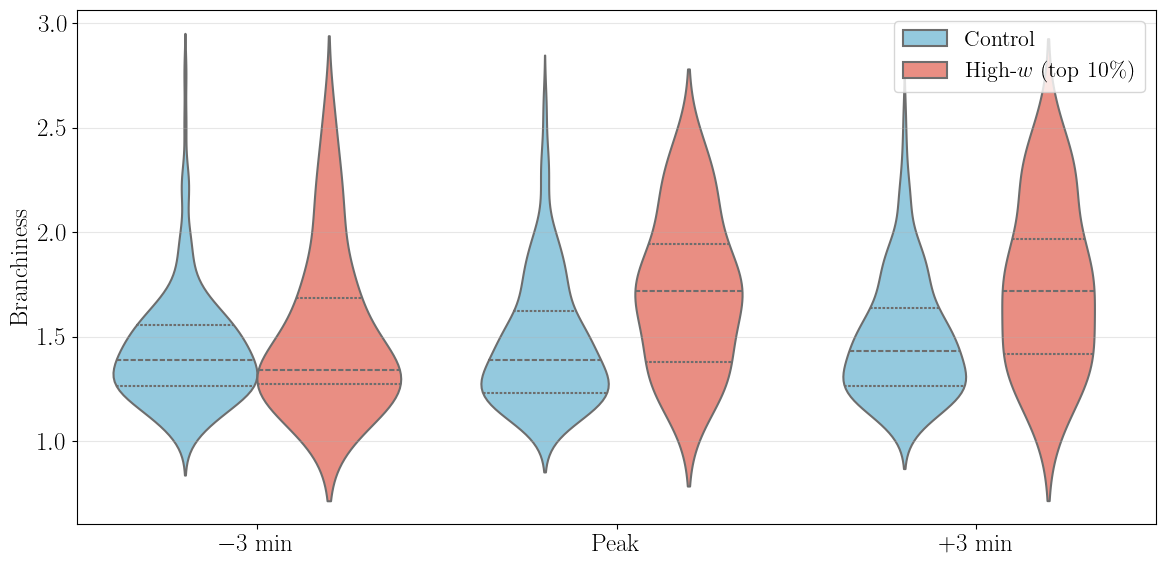

In [77]:
# ============================================================================
# VIOLIN PLOT: Branchiness Evolution Around Peak Updraft
# ============================================================================
# Enhanced visualization with seaborn, desaturated colors, and LaTeX formatting
# Vertical lines in violins show quartiles (25th, 50th/median, 75th percentiles)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import rc
from scipy.stats import mannwhitneyu

# Enable LaTeX and set font size to 18
rc('text', usetex=True)
rc('font', size=18)

# ============================================================================
# COLOR SELECTION - Choose any CSS/named matplotlib colors
# ============================================================================
# Popular options: 'blue', 'red', 'green', 'orange', 'purple', 'cyan', 
#                  'steelblue', 'crimson', 'darkblue', 'darkred', 'navy',
#                  'royalblue', 'firebrick', 'indianred', 'cornflowerblue'
# Full list: https://matplotlib.org/stable/gallery/color/named_colors.html
control_color = 'skyblue'    # Color for control clouds
high_w_color = 'salmon'       # Color for high-w clouds
# ============================================================================

df_high = lag_results['before_after_data']['high_w']
df_control = lag_results['before_after_data']['control']
minutes = lag_results['minutes_offset']
w_threshold = lag_results['w_threshold']

if not df_control.empty and not df_high.empty:
    # Define group label with LaTeX
    high_w_label = r'High-$w$ (top 10\%)'
    
    # Prepare data in long format for seaborn
    control_data = pd.DataFrame({
        'Branchiness': pd.concat([
            df_control['branch_before'],
            df_control['branch_peak'],
            df_control['branch_after']
        ]),
        'Time': [f'$-${minutes} min'] * len(df_control) + ['Peak'] * len(df_control) + [f'$+${minutes} min'] * len(df_control),
        'Group': 'Control'
    })
    
    high_w_data = pd.DataFrame({
        'Branchiness': pd.concat([
            df_high['branch_before'],
            df_high['branch_peak'],
            df_high['branch_after']
        ]),
        'Time': [f'$-${minutes} min'] * len(df_high) + ['Peak'] * len(df_high) + [f'$+${minutes} min'] * len(df_high),
        'Group': high_w_label
    })
    
    # Combine data
    plot_data = pd.concat([control_data, high_w_data], ignore_index=True)
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # Create violin plot with seaborn
    sns.violinplot(
        data=plot_data,
        x='Time',
        y='Branchiness',
        hue='Group',
        palette={'Control': control_color, high_w_label: high_w_color},
        order=[f'$-${minutes} min', 'Peak', f'$+${minutes} min'],
        split=False,
        inner='quartile',
        linewidth=1.5,
        ax=ax
    )
    
    # Customize plot
    ax.set_ylabel(r'Branchiness', fontsize=18)
    ax.set_xlabel('')
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(frameon=True, fontsize=16)
    
    # Save figure as PDF with transparent background
    plt.savefig('branchiness_evolution_violin.pdf', bbox_inches='tight', dpi=300, transparent=True)
    print("Figure saved as: branchiness_evolution_violin.pdf (transparent background)")
    
    # Print important statistics
    print("="*70)
    print("STATISTICAL SUMMARY: Branchiness Around Peak Updraft")
    print(f"High-w threshold: {w_threshold:.3f} m/s (top 10% of clouds)")
    print("="*70)
    
    print(f"\nControl clouds (n={len(df_control)}):")
    print(f"  Before (-{minutes} min): {df_control['branch_before'].mean():.3f} ± {df_control['branch_before'].std():.3f}")
    print(f"  Peak:                    {df_control['branch_peak'].mean():.3f} ± {df_control['branch_peak'].std():.3f}")
    print(f"  After  (+{minutes} min): {df_control['branch_after'].mean():.3f} ± {df_control['branch_after'].std():.3f}")
    
    print(f"\nHigh-w clouds (n={len(df_high)}):")
    print(f"  Before (-{minutes} min): {df_high['branch_before'].mean():.3f} ± {df_high['branch_before'].std():.3f}")
    print(f"  Peak:                    {df_high['branch_peak'].mean():.3f} ± {df_high['branch_peak'].std():.3f}")
    print(f"  After  (+{minutes} min): {df_high['branch_after'].mean():.3f} ± {df_high['branch_after'].std():.3f}")
    
    # Statistical tests
    print("\n" + "-"*70)
    print("Statistical Tests (Mann-Whitney U):")
    print("-"*70)
    
    # Compare changes
    for metric, label in [
        ('change_before_to_peak', f'Change: -{minutes} min to peak'),
        ('change_peak_to_after', f'Change: peak to +{minutes} min'),
        ('change_before_to_after', f'Change: -{minutes} min to +{minutes} min')
    ]:
        stat, p_val = mannwhitneyu(df_high[metric], df_control[metric], alternative='two-sided')
        sig_marker = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else "ns"))
        print(f"{label:40s} p = {p_val:.4e} {sig_marker}")
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Insufficient data for violin plot")


The above is looking for a lagged effect: Do clouds that achieve very strong peak updrafts tend to increase their branchiness more in the next 1–2 minutes than clouds with weaker peaks? The answer is no, so: looked for a clear lagged effect and didn’t find one.

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_37547/2962773008.py:49: RuntimeWarning: All-NaN slice encountered
  max_w = np.nanmax(w_pos, axis=2)  # (track, time)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_37547/4037684917.py:137: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap(color_map)(w_norm)



Branchiness time series centered on peak-w:
High-w threshold: 1.404 m/s
High-w clouds: 227
Control clouds: 2042


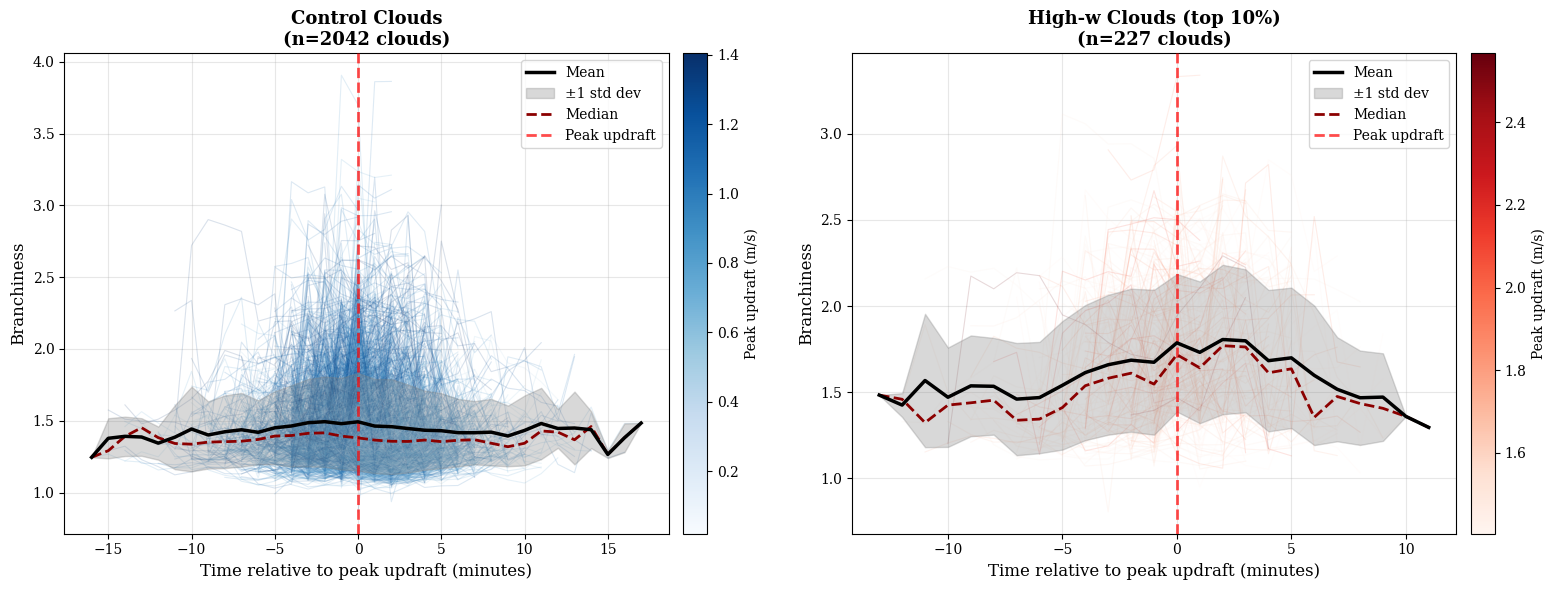

In [28]:
## ============================================================================
## VISUALIZATION 4: Branchiness Evolution Centered on Peak-w Time
## ============================================================================

def plot_branchiness_timeseries_centered(raw, df_tracks, 
                                          percentile_threshold=90,
                                          min_age_minutes=5, 
                                          min_size_points=50, 
                                          dt_seconds=60,
                                          voxel_dx=25.0, voxel_dy=25.0, voxel_dz=25.0):
    """
    Plot branchiness time series for each cloud, centered on their peak updraft moment.
    X-axis: time relative to peak-w (minutes)
    Y-axis: branchiness
    """
    
    # Compute time series
    branchiness = compute_branchiness_timeseries(raw, voxel_dx, voxel_dy, voxel_dz)
    max_w = compute_max_w_timeseries(raw)
    size = raw.get('size', None)
    age_array = raw.get('age', None)
    
    if branchiness is None or max_w is None or size is None:
        print("Missing required data!")
        return
    
    idx = df_tracks.track_index.values
    branchiness = branchiness[idx, :]
    max_w = max_w[idx, :]
    size = size[idx, :]
    
    # Calculate cloud lifetimes and max sizes
    if age_array is not None:
        age_array = age_array[idx, :]
        valid_timesteps = (size > 0) & np.isfinite(size)
        ages = np.array([
            np.max(age_array[i, valid_timesteps[i]]) if np.any(valid_timesteps[i]) else np.nan
            for i in range(len(idx))
        ])
        ages = (ages + 1) * dt_seconds / 60.0
    else:
        ages = df_tracks.lifetime.values * dt_seconds / 60.0
    
    max_sizes = np.nanmax(size, axis=1)
    
    # Filter tracks
    valid_tracks = (ages >= min_age_minutes) & (max_sizes >= min_size_points)
    
    n_tracks, n_time = size.shape
    
    # Find peak-w timestep for each cloud
    cloud_max_w = np.full(n_tracks, np.nan)
    cloud_max_w_timestep = np.full(n_tracks, -1, dtype=int)
    
    for i in range(n_tracks):
        if not valid_tracks[i]:
            continue
        
        valid_mask = (size[i, :] > 0) & np.isfinite(size[i, :]) & np.isfinite(max_w[i, :]) & np.isfinite(branchiness[i, :])
        if not np.any(valid_mask):
            continue
        
        valid_w = max_w[i, valid_mask]
        valid_timesteps_idx = np.where(valid_mask)[0]
        max_w_idx = np.argmax(valid_w)
        
        cloud_max_w[i] = valid_w[max_w_idx]
        cloud_max_w_timestep[i] = valid_timesteps_idx[max_w_idx]
    
    # Determine threshold
    valid_cloud_w = cloud_max_w[np.isfinite(cloud_max_w)]
    w_threshold = np.nanpercentile(valid_cloud_w, percentile_threshold)
    
    high_w_clouds = (cloud_max_w >= w_threshold) & np.isfinite(cloud_max_w)
    
    print(f"\nBranchiness time series centered on peak-w:")
    print(f"High-w threshold: {w_threshold:.3f} m/s")
    print(f"High-w clouds: {high_w_clouds.sum()}")
    print(f"Control clouds: {(valid_tracks & ~high_w_clouds).sum()}")
    
    # Collect data for each cloud, centered on peak-w
    high_w_data = []
    control_data = []
    
    for i in range(n_tracks):
        if not valid_tracks[i]:
            continue
        
        t_peak = cloud_max_w_timestep[i]
        if t_peak < 0:
            continue
        
        # Get valid timesteps for this cloud
        valid_mask = (size[i, :] > 0) & np.isfinite(branchiness[i, :])
        valid_timesteps_idx = np.where(valid_mask)[0]
        
        if len(valid_timesteps_idx) == 0:
            continue
        
        # Time relative to peak (in minutes)
        time_rel = (valid_timesteps_idx - t_peak) * dt_seconds / 60.0
        branch_vals = branchiness[i, valid_timesteps_idx]
        w_peak = cloud_max_w[i]
        
        cloud_data = {
            'time_rel': time_rel,
            'branchiness': branch_vals,
            'w_peak': w_peak,
            'track_id': i
        }
        
        if high_w_clouds[i]:
            high_w_data.append(cloud_data)
        else:
            control_data.append(cloud_data)
    
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    for ax, data_list, title, color_map in zip(
        axes,
        [control_data, high_w_data],
        ['Control Clouds', f'High-w Clouds (top {100-percentile_threshold:.0f}%)'],
        ['Blues', 'Reds']
    ):
        if len(data_list) == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            continue
        
        # Plot individual cloud lines
        all_w_peaks = [d['w_peak'] for d in data_list]
        w_min, w_max = np.min(all_w_peaks), np.max(all_w_peaks)
        
        for cloud_data in data_list:
            # Normalize w_peak for color mapping
            w_norm = (cloud_data['w_peak'] - w_min) / (w_max - w_min) if w_max > w_min else 0.5
            color = plt.cm.get_cmap(color_map)(w_norm)
            
            ax.plot(cloud_data['time_rel'], cloud_data['branchiness'], 
                   alpha=0.15, lw=0.8, color=color)
        
        # Compute mean and std dev at each time point
        # Find common time grid
        all_times = np.concatenate([d['time_rel'] for d in data_list])
        time_min, time_max = all_times.min(), all_times.max()
        time_grid = np.arange(np.floor(time_min), np.ceil(time_max) + 1, 1)  # 1-minute bins
        
        mean_branch = []
        std_branch = []
        median_branch = []
        
        for t in time_grid:
            # Collect all branchiness values within ±0.5 min of this time
            values = []
            for cloud_data in data_list:
                mask = np.abs(cloud_data['time_rel'] - t) < 0.5
                if np.any(mask):
                    values.extend(cloud_data['branchiness'][mask])
            
            if len(values) > 0:
                mean_branch.append(np.mean(values))
                std_branch.append(np.std(values))
                median_branch.append(np.median(values))
            else:
                mean_branch.append(np.nan)
                std_branch.append(np.nan)
                median_branch.append(np.nan)
        
        mean_branch = np.array(mean_branch)
        std_branch = np.array(std_branch)
        median_branch = np.array(median_branch)
        
        # Plot mean ± std
        ax.plot(time_grid, mean_branch, color='black', lw=2.5, label='Mean', zorder=10)
        ax.fill_between(time_grid, mean_branch - std_branch, mean_branch + std_branch,
                       color='gray', alpha=0.3, label='±1 std dev', zorder=5)
        
        # Plot median
        ax.plot(time_grid, median_branch, color='darkred', lw=2, ls='--', 
               label='Median', zorder=9)
        
        # Add vertical line at t=0 (peak-w moment)
        ax.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, 
                  label='Peak updraft', zorder=8)
        
        ax.set_xlabel('Time relative to peak updraft (minutes)', fontsize=12)
        ax.set_ylabel('Branchiness', fontsize=12)
        ax.set_title(f'{title}\n(n={len(data_list)} clouds)', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
        
        # Add colorbar for w_peak
        sm = plt.cm.ScalarMappable(cmap=color_map, 
                                   norm=plt.Normalize(vmin=w_min, vmax=w_max))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, label='Peak updraft (m/s)', pad=0.02)
        cbar.ax.tick_params(labelsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return high_w_data, control_data


# Run the visualization
high_w_ts, control_ts = plot_branchiness_timeseries_centered(
    raw, df_tracks,
    percentile_threshold=90,
    min_age_minutes=5,
    min_size_points=10,
    dt_seconds=60,
    voxel_dx=25.0,
    voxel_dy=25.0,
    voxel_dz=25.0
)

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_37547/3308527039.py:64: RuntimeWarning: All-NaN slice encountered
  max_w = np.nanmax(w_pos, axis=2)  # (track, time)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_37547/1427653057.py:32: RuntimeWarning: Mean of empty slice
  mean_w = np.nanmean(w_per_level, axis=2)  # (track, time)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_37547/1427653057.py:32: RuntimeWarning: Mean of empty slice
  mean_w = np.nanmean(w_per_level, axis=2)  # (track, time)



Mean vertical velocity time series centered on peak-w:
High-w threshold: 1.404 m/s
High-w clouds: 227
Control clouds: 2042


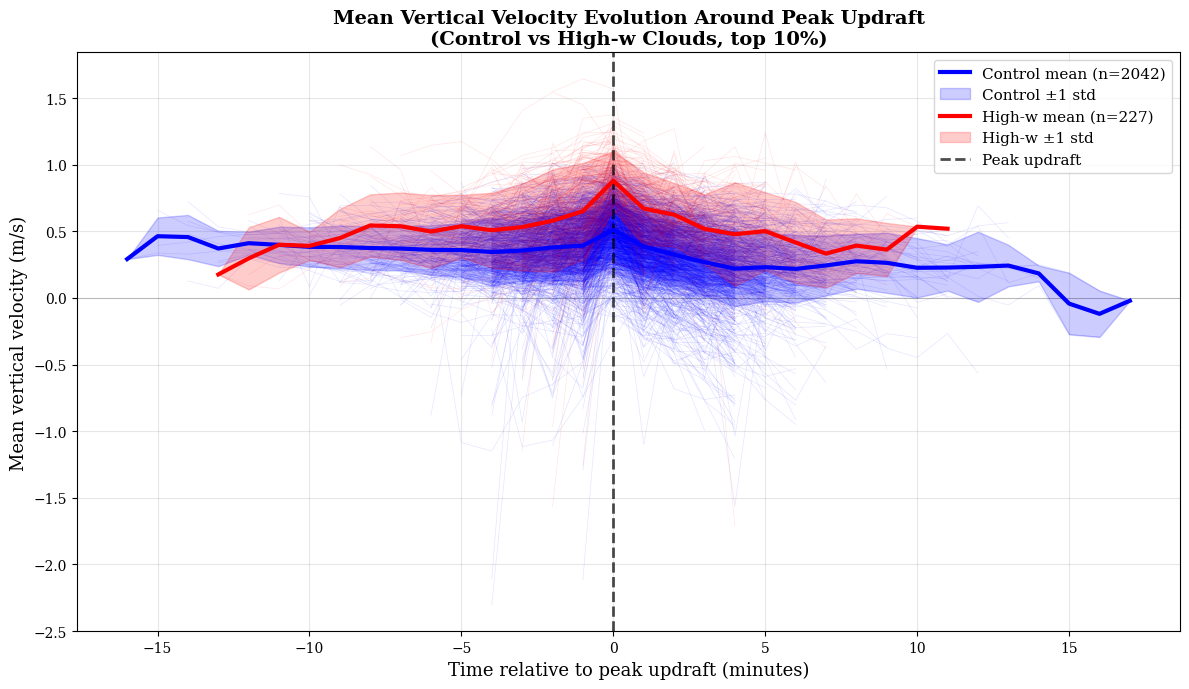

In [41]:
## ============================================================================
## VISUALIZATION 5: Mean Vertical Velocity Evolution Centered on Peak-w Time
## ============================================================================

def plot_mean_w_timeseries_centered(raw, df_tracks, 
                                     percentile_threshold=90,
                                     min_age_minutes=5, 
                                     min_size_points=50, 
                                     dt_seconds=60):
    """
    Plot mean vertical velocity time series for each cloud, centered on their peak updraft moment.
    X-axis: time relative to peak-w (minutes)
    Y-axis: mean vertical velocity (m/s)
    """
    
    # Compute time series
    max_w = compute_max_w_timeseries(raw)
    w_per_level = raw.get('w_per_level', None)  # (track, time, level)
    size = raw.get('size', None)
    age_array = raw.get('age', None)
    
    if max_w is None or w_per_level is None or size is None:
        print("Missing required data!")
        return
    
    idx = df_tracks.track_index.values
    max_w = max_w[idx, :]
    w_per_level = w_per_level[idx, :, :]
    size = size[idx, :]
    
    # Compute mean w (averaged across all levels at each timestep)
    mean_w = np.nanmean(w_per_level, axis=2)  # (track, time)
    
    # Calculate cloud lifetimes and max sizes
    if age_array is not None:
        age_array = age_array[idx, :]
        valid_timesteps = (size > 0) & np.isfinite(size)
        ages = np.array([
            np.max(age_array[i, valid_timesteps[i]]) if np.any(valid_timesteps[i]) else np.nan
            for i in range(len(idx))
        ])
        ages = (ages + 1) * dt_seconds / 60.0
    else:
        ages = df_tracks.lifetime.values * dt_seconds / 60.0
    
    max_sizes = np.nanmax(size, axis=1)
    
    # Filter tracks
    valid_tracks = (ages >= min_age_minutes) & (max_sizes >= min_size_points)
    
    n_tracks, n_time = size.shape
    
    # Find peak-w timestep for each cloud
    cloud_max_w = np.full(n_tracks, np.nan)
    cloud_max_w_timestep = np.full(n_tracks, -1, dtype=int)
    
    for i in range(n_tracks):
        if not valid_tracks[i]:
            continue
        
        valid_mask = (size[i, :] > 0) & np.isfinite(size[i, :]) & np.isfinite(max_w[i, :]) & np.isfinite(mean_w[i, :])
        if not np.any(valid_mask):
            continue
        
        valid_w = max_w[i, valid_mask]
        valid_timesteps_idx = np.where(valid_mask)[0]
        max_w_idx = np.argmax(valid_w)
        
        cloud_max_w[i] = valid_w[max_w_idx]
        cloud_max_w_timestep[i] = valid_timesteps_idx[max_w_idx]
    
    # Determine threshold
    valid_cloud_w = cloud_max_w[np.isfinite(cloud_max_w)]
    w_threshold = np.nanpercentile(valid_cloud_w, percentile_threshold)
    
    high_w_clouds = (cloud_max_w >= w_threshold) & np.isfinite(cloud_max_w)
    
    print(f"\nMean vertical velocity time series centered on peak-w:")
    print(f"High-w threshold: {w_threshold:.3f} m/s")
    print(f"High-w clouds: {high_w_clouds.sum()}")
    print(f"Control clouds: {(valid_tracks & ~high_w_clouds).sum()}")
    
    # Collect data for each cloud, centered on peak-w
    high_w_data = []
    control_data = []
    
    for i in range(n_tracks):
        if not valid_tracks[i]:
            continue
        
        t_peak = cloud_max_w_timestep[i]
        if t_peak < 0:
            continue
        
        # Get valid timesteps for this cloud
        valid_mask = (size[i, :] > 0) & np.isfinite(mean_w[i, :])
        valid_timesteps_idx = np.where(valid_mask)[0]
        
        if len(valid_timesteps_idx) == 0:
            continue
        
        # Time relative to peak (in minutes)
        time_rel = (valid_timesteps_idx - t_peak) * dt_seconds / 60.0
        w_vals = mean_w[i, valid_timesteps_idx]
        w_peak = cloud_max_w[i]
        
        cloud_data = {
            'time_rel': time_rel,
            'mean_w': w_vals,
            'w_peak': w_peak,
            'track_id': i
        }
        
        if high_w_clouds[i]:
            high_w_data.append(cloud_data)
        else:
            control_data.append(cloud_data)
    
    # Create single combined plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    
    # Combine all data
    all_data = control_data + high_w_data
    
    if len(all_data) == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
    else:
        # Plot individual cloud lines
        for cloud_data in control_data:
            ax.plot(cloud_data['time_rel'], cloud_data['mean_w'], 
                   alpha=0.1, lw=0.5, color='blue')
        
        for cloud_data in high_w_data:
            ax.plot(cloud_data['time_rel'], cloud_data['mean_w'], 
                   alpha=0.1, lw=0.5, color='red')
        
        # Compute mean and std dev for each group
        all_times = np.concatenate([d['time_rel'] for d in all_data])
        time_min, time_max = all_times.min(), all_times.max()
        time_grid = np.arange(np.floor(time_min), np.ceil(time_max) + 1, 1)
        
        # Control group statistics
        mean_w_control = []
        std_w_control = []
        for t in time_grid:
            values = []
            for cloud_data in control_data:
                mask = np.abs(cloud_data['time_rel'] - t) < 0.5
                if np.any(mask):
                    values.extend(cloud_data['mean_w'][mask])
            mean_w_control.append(np.mean(values) if len(values) > 0 else np.nan)
            std_w_control.append(np.std(values) if len(values) > 0 else np.nan)
        
        mean_w_control = np.array(mean_w_control)
        std_w_control = np.array(std_w_control)
        
        # High-w group statistics
        mean_w_high = []
        std_w_high = []
        for t in time_grid:
            values = []
            for cloud_data in high_w_data:
                mask = np.abs(cloud_data['time_rel'] - t) < 0.5
                if np.any(mask):
                    values.extend(cloud_data['mean_w'][mask])
            mean_w_high.append(np.mean(values) if len(values) > 0 else np.nan)
            std_w_high.append(np.std(values) if len(values) > 0 else np.nan)
        
        mean_w_high = np.array(mean_w_high)
        std_w_high = np.array(std_w_high)
        
        # Plot control mean ± std
        ax.plot(time_grid, mean_w_control, color='blue', lw=3, 
               label=f'Control mean (n={len(control_data)})', zorder=10)
        ax.fill_between(time_grid, mean_w_control - std_w_control, mean_w_control + std_w_control,
                       color='blue', alpha=0.2, label='Control ±1 std', zorder=5)
        
        # Plot high-w mean ± std
        ax.plot(time_grid, mean_w_high, color='red', lw=3, 
               label=f'High-w mean (n={len(high_w_data)})', zorder=10)
        ax.fill_between(time_grid, mean_w_high - std_w_high, mean_w_high + std_w_high,
                       color='red', alpha=0.2, label='High-w ±1 std', zorder=5)
        
        # Add reference lines
        ax.axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.7, 
                  label='Peak updraft', zorder=8)
        ax.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
        
        ax.set_xlabel('Time relative to peak updraft (minutes)', fontsize=13)
        ax.set_ylabel('Mean vertical velocity (m/s)', fontsize=13)
        ax.set_title(f'Mean Vertical Velocity Evolution Around Peak Updraft\n(Control vs High-w Clouds, top {100-percentile_threshold:.0f}%)', 
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=11, loc='best')
    
    plt.tight_layout()
    plt.show()
    
    return high_w_data, control_data


# Run the visualization
high_w_w_data, control_w_data = plot_mean_w_timeseries_centered(
    raw, df_tracks,
    percentile_threshold=90,
    min_age_minutes=5,
    min_size_points=10,
    dt_seconds=60
)

## For AGU (end)

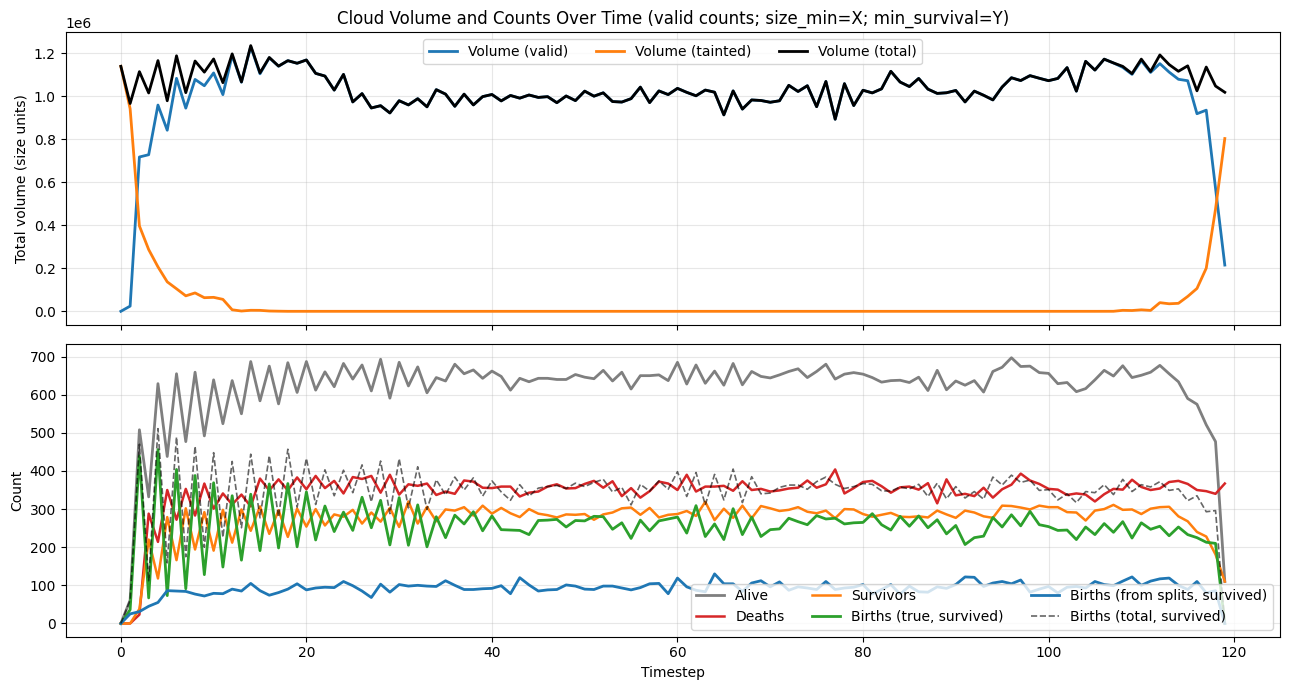

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

def compute_cloud_time_series_stable_births(
    nc_path,
    size_min=0,            # exclude clouds smaller than this from counts AND volumes
    min_survival=3,        # require births to survive at least this many steps
    counts_valid_only=True # restrict counts to valid (complete lifecycle) tracks
):
    with Dataset(nc_path, 'r') as ds:
        size = np.asarray(np.ma.filled(ds.variables['size'][:], np.nan), dtype=float)  # (track,time)
        n_tracks, n_time = size.shape
        valid_mask = (np.asarray(ds.variables['valid_track'][:]) == 1)                # (track,)
        split_from = ds.variables.get('split_from')
        split = (np.asarray(np.ma.filled(split_from[:], -1), dtype=int)
                 if split_from is not None else np.full_like(size, -1, dtype=int))

        # Threshold by size for both counts and volumes
        size_thr = size.copy()
        if size_min > 0:
            size_thr[size_thr < size_min] = np.nan

        # Volumes (valid, tainted, total)
        volume_total   = np.nansum(size_thr, axis=0)
        volume_valid   = np.nansum(np.where(valid_mask[:, None], size_thr, np.nan), axis=0)
        volume_tainted = np.nansum(np.where(~valid_mask[:, None], size_thr, np.nan), axis=0)

        # Counts base array (optionally restrict to valid tracks)
        size_cnt = size_thr.copy()
        if counts_valid_only:
            size_cnt[~valid_mask, :] = np.nan

        alive = np.isfinite(size_cnt)                    # (track,time) bool
        alive_count = alive.sum(axis=0).astype(int)

        # Birth/death/survivor primitives
        births_raw = np.zeros_like(alive, dtype=bool)
        births_raw[:, 0] = alive[:, 0]
        if n_time > 1:
            births_raw[:, 1:] = alive[:, 1:] & ~alive[:, :-1]

        alive_prev = np.zeros_like(alive, dtype=bool)
        alive_prev[:, 1:] = alive[:, :-1]
        deaths     = (alive_prev & ~alive).sum(axis=0).astype(int)
        survivors  = (alive_prev &  alive).sum(axis=0).astype(int)

        # Survival length from each timestep (consecutive alive run length)
        survival_len = np.zeros_like(alive, dtype=int)
        for t in range(n_time - 1, -1, -1):
            if t == n_time - 1:
                survival_len[:, t] = alive[:, t].astype(int)
            else:
                survival_len[:, t] = np.where(alive[:, t], 1 + survival_len[:, t + 1], 0)

        births_survive = births_raw & (survival_len >= int(min_survival))

        # Classify births (true vs from splits), after survival filter
        split_mask = (split >= 0)
        births_from_splits_surv = (births_survive & split_mask).sum(axis=0).astype(int)
        births_true_surv        = (births_survive & ~split_mask).sum(axis=0).astype(int)
        births_total_surv       = births_true_surv + births_from_splits_surv

    return dict(
        # volumes
        volume_valid=volume_valid,
        volume_tainted=volume_tainted,
        volume_total=volume_total,
        # counts
        alive=alive_count,
        deaths=deaths,
        survivors=survivors,
        births_true=births_true_surv,
        births_from_splits=births_from_splits_surv,
        births_total=births_total_surv
    )


def plot_cloud_time_series_stable_births(series, title_suffix=""):
    t = np.arange(series['alive'].size)
    fig, axes = plt.subplots(2, 1, figsize=(13, 7), sharex=True)

    # Top: volumes
    axes[0].plot(t, series['volume_valid'],   lw=2, label='Volume (valid)')
    axes[0].plot(t, series['volume_tainted'], lw=2, label='Volume (tainted)')
    axes[0].plot(t, series['volume_total'],   lw=2, color='k', label='Volume (total)')
    axes[0].set_ylabel('Total volume (size units)')
    axes[0].set_title(f'Cloud Volume and Counts Over Time {title_suffix}')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(ncol=3)

    # Bottom: counts with survival-filtered births
    axes[1].plot(t, series['alive'],      lw=2, label='Alive', color='tab:gray')
    axes[1].plot(t, series['deaths'],     lw=1.8, label='Deaths', color='tab:red')
    axes[1].plot(t, series['survivors'],  lw=1.8, label='Survivors', color='tab:orange')
    axes[1].plot(t, series['births_true'],        lw=2, label='Births (true, survived)', color='tab:green')
    axes[1].plot(t, series['births_from_splits'], lw=2, label='Births (from splits, survived)', color='tab:blue')
    axes[1].plot(t, series['births_total'],       lw=1.2, ls='--', color='k', alpha=0.6, label='Births (total, survived)')

    axes[1].set_xlabel('Timestep')
    axes[1].set_ylabel('Count')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(ncol=3)

    plt.tight_layout()
    plt.show()




nc_path = '../output_archive/cloud_results_120mins.nc'   
series = compute_cloud_time_series_stable_births(
    nc_path,
    size_min=10,        
    min_survival=0,     # require a few consecutive timesteps after birth
    counts_valid_only=True
)
plot_cloud_time_series_stable_births(series, title_suffix="(valid counts; size_min=X; min_survival=Y)")
